In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet
from scipy.stats import gaussian_kde, kurtosis, skew, norm
import warnings

warnings.filterwarnings('ignore')

# Global definitions for column names and units
COLUMNS = {
    'daily': ['TMAX', 'TAVG', 'TMIN', 'PRCP', 'SNWD'],
    'monthly': ['EMXP', 'EMXT', 'DSND', 'PRCP', 'DX90', 'DP10', 'HDSD', 'HTDD', 'DX70', 'DP01', 'CDSD', 'EMNT', 'DT32', 'DT00', 'DX32', 'CLDD', 'TMAX', 'EMSD', 'TAVG', 'TMIN'],
    'yearly': ['EMXP', 'EMXT', 'PRCP', 'DX90', 'DP10', 'DX70', 'EMNT', 'DT32', 'DX32', 'TMAX', 'EMSD', 'TAVG', 'TMIN']
}

COLUMN_NAMES = {
    'daily': ['Maximum Temperature', 'Average Temperature', 'Minimum Temperature', 'Precipitation', 'Snow Depth'],
    'monthly': ['Extreme Maximum Precipitation', 'Extreme Maximum Temperature', 'Number of Days with Snow Depth > 1 inch',
                'Precipitation', 'Number of Days with Maximum Temperature > 90°F', 'Number of Days with >= 1.0 inch of Precipitation',
                'Heating Degree Days Season to Date', 'Heating Degree Days', 'Number of Days with Maximum Temperature > 70°F',
                'Number of Days with >= 0.1 inch of Precipitation', 'Cooling Degree Days Season to Date', 'Extreme Minimum Temperature',
                'Number of Days with Minimum Temperature <= 32°F', 'Number of Days with Minimum Temperature <= 0.0°F',
                'Number of Days with Maximum Temperature < 32°F', 'Cooling Degree Days', 'Maximum Temperature',
                'Extreme Maximum Snow Depth', 'Average Temperature', 'Minimum Temperature'],
    'yearly': ['Extreme Maximum Precipitation', 'Extreme Maximum Temperature', 'Precipitation', 'Number of Days with Maximum Temperature > 90°F',
               'Number of Days with >= 1.0 inch of Precipitation', 'Number of Days with Maximum Temperature > 70°F',
               'Extreme Minimum Temperature', 'Number of Days with Minimum Temperature <= 32°F',
               'Number of Days with Maximum Temperature < 32°F', 'Maximum Temperature', 'Extreme Maximum Snow Depth',
               'Average Temperature', 'Minimum Temperature']
}

UNITS = {
    'daily': ['°C', '°C', '°C', 'mm', 'mm'],
    'monthly': ['mm', '°C', 'days', 'mm', 'days', 'days', 'degree-days', 'degree-days', 'days', 'days', 'degree-days', '°C', 'days', 'days', 'days', 'degree-days', '°C', 'mm', '°C', '°C'],
    'yearly': ['mm', '°C', 'mm', 'days', 'days', 'days', '°C', 'days', 'days', '°C', 'mm', '°C', '°C']
}


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet
from scipy.stats import gaussian_kde, kurtosis, skew, norm
import warnings

warnings.filterwarnings('ignore')

# Global definitions for column names and units
COLUMNS = {
    'daily': ['TMAX', 'TAVG', 'TMIN', 'PRCP', 'SNWD'],
    'monthly': ['EMXP', 'EMXT', 'DSND', 'PRCP', 'DX90', 'DP10', 'HDSD', 'HTDD', 'DX70', 'DP01', 'CDSD', 'EMNT', 'DT32', 'DT00', 'DX32', 'CLDD', 'TMAX', 'EMSD', 'TAVG', 'TMIN'],
    'yearly': ['EMXP', 'EMXT', 'PRCP', 'DX90', 'DP10', 'DX70', 'EMNT', 'DT32', 'DX32', 'TMAX', 'EMSD', 'TAVG', 'TMIN']
}

COLUMN_NAMES = {
    'daily': ['Maximum Temperature', 'Average Temperature', 'Minimum Temperature', 'Precipitation', 'Snow Depth'],
    'monthly': ['Extreme Maximum Precipitation', 'Extreme Maximum Temperature', 'Number of Days with Snow Depth > 1 inch',
                'Precipitation', 'Number of Days with Maximum Temperature > 90°F', 'Number of Days with >= 1.0 inch of Precipitation',
                'Heating Degree Days Season to Date', 'Heating Degree Days', 'Number of Days with Maximum Temperature > 70°F',
                'Number of Days with >= 0.1 inch of Precipitation', 'Cooling Degree Days Season to Date', 'Extreme Minimum Temperature',
                'Number of Days with Minimum Temperature <= 32°F', 'Number of Days with Minimum Temperature <= 0.0°F',
                'Number of Days with Maximum Temperature < 32°F', 'Cooling Degree Days', 'Maximum Temperature',
                'Extreme Maximum Snow Depth', 'Average Temperature', 'Minimum Temperature'],
    'yearly': ['Extreme Maximum Precipitation', 'Extreme Maximum Temperature', 'Precipitation', 'Number of Days with Maximum Temperature > 90°F',
               'Number of Days with >= 1.0 inch of Precipitation', 'Number of Days with Maximum Temperature > 70°F',
               'Extreme Minimum Temperature', 'Number of Days with Minimum Temperature <= 32°F',
               'Number of Days with Maximum Temperature < 32°F', 'Maximum Temperature', 'Extreme Maximum Snow Depth',
               'Average Temperature', 'Minimum Temperature']
}

UNITS = {
    'daily': ['°C', '°C', '°C', 'mm', 'mm'],
    'monthly': ['mm', '°C', 'days', 'mm', 'days', 'days', 'degree-days', 'degree-days', 'days', 'days', 'degree-days', '°C', 'days', 'days', 'days', 'degree-days', '°C', 'mm', '°C', '°C'],
    'yearly': ['mm', '°C', 'mm', 'days', 'days', 'days', '°C', 'days', 'days', '°C', 'mm', '°C', '°C']
}

# Function to fill NA values with the mean of each numeric column
def fill_na_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        mean_value = df[col].mean()
        df[col] = df[col].fillna(mean_value)
    return df

# Load and preprocess datasets
def load_and_preprocess_data():
    try:
        # Load the datasets
        daily_data = pd.read_csv('Daily Summaries - GHCND.csv', parse_dates=['DATE'], index_col='DATE')
        monthly_data = pd.read_csv('Global Summary of the Month - GSOM.csv', parse_dates=['DATE'], index_col='DATE')
        yearly_data = pd.read_csv('Global Summary of The Year - GSOY.csv', parse_dates=['DATE'], index_col='DATE')

        # Ensure the data is loaded correctly
        if daily_data.empty or monthly_data.empty or yearly_data.empty:
            raise ValueError("One of the datasets is empty. Please check the files.")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None, None
    except pd.errors.ParserError as e:
        print(f"Parsing error: {e}")
        return None, None, None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None, None, None

    # Sort data by date
    daily_data = daily_data.sort_index()
    monthly_data = monthly_data.sort_index()
    yearly_data = yearly_data.sort_index()

    # Fill missing values
    daily_data = fill_na_with_mean(daily_data)
    monthly_data = fill_na_with_mean(monthly_data)
    yearly_data = fill_na_with_mean(yearly_data)
    
    return daily_data, monthly_data, yearly_data

# Load and preprocess the data
daily_data, monthly_data, yearly_data = load_and_preprocess_data()

if daily_data is None or monthly_data is None or yearly_data is None:
    print("Data loading failed. Please check the file paths and formats.")
else:
    print("Data loaded and preprocessed successfully.")

Data loaded and preprocessed successfully.


In [3]:
# Group by station to calculate the mean of each parameter
station_aggregated_data = daily_data.groupby(['STATION', 'NAME']).agg({
    'TMAX': 'mean',
    'TMIN': 'mean',
    'PRCP': 'sum',
    'SNWD': 'sum'
}).reset_index()

# Find the top 5 stations based on each parameter
top5_tmax = station_aggregated_data.nlargest(5, 'TMAX')
top5_tmin = station_aggregated_data.nlargest(5, 'TMIN')
top5_prcp = station_aggregated_data.nlargest(5, 'PRCP')
top5_snwd = station_aggregated_data.nlargest(5, 'SNWD')
lowest5_prcp = station_aggregated_data.nsmallest(5, 'PRCP')
lowest5_snwd = station_aggregated_data.nsmallest(5, 'SNWD')

# Display the top 5 stations for each parameter
print("Top 5 Stations based on the highest average maximum temperature (TMAX):")
print(top5_tmax)
print("\nTop 5 Stations based on the highest average minimum temperature (TMIN):")
print(top5_tmin)
print("\nTop 5 Stations based on the highest total precipitation (PRCP):")
print(top5_prcp)
print("\nTop 5 Stations based on the highest total snow depth (SNWD):")
print(top5_snwd)
print("\nTop 5 Stations based on the lowest total precipitation (PRCP):")
print(lowest5_prcp)
print("\nTop 5 Stations based on the lowest total snow depth (SNWD):")
print(lowest5_snwd)


Top 5 Stations based on the highest average maximum temperature (TMAX):
        STATION                   NAME       TMAX      TMIN         PRCP  \
74  UKE00156884             WISLEY, UK  16.027401  6.878126  3096.429792   
13  UKE00105648  CAMBRIDGE B. GDNS, UK  15.747696  6.869636  2766.284013   
56  UKE00105923               HURN, UK  15.719016  6.671778  4019.629792   
60  UKE00107962          YEOVILTON, UK  15.545936  6.887084  3308.800000   
87  UKM00003772           HEATHROW, UK  15.489456  7.318098  2980.777547   

           SNWD  
74  1781.247337  
13  1716.975525  
56     0.000000  
60  1781.247337  
87  1948.303484  

Top 5 Stations based on the highest average minimum temperature (TMIN):
        STATION                           NAME       TMAX      TMIN  \
73  UKE00156880  WIGHT ST CATHERINES POINT, UK  14.097878  9.572654   
23  UKE00105869                    SWANAGE, UK  14.751168  9.020747   
5   UK000003808                   CAMBORNE, UK  14.137688  8.977448   
54  UK

In [4]:
# Function to display summary statistics for specific columns
def display_summary_statistics(df, name, columns):
    if df.empty:
        print(f"No data available for {name}.")
    else:
        print(f"\nSummary Statistics for {name}:\n")
        print(df[columns].describe())
    
# Display summary statistics for each dataset based on global definitions
display_summary_statistics(daily_data, 'Daily Data', COLUMNS['daily'])
display_summary_statistics(monthly_data, 'Monthly Data', COLUMNS['monthly'])
display_summary_statistics(yearly_data, 'Yearly Data', COLUMNS['yearly'])


Summary Statistics for Daily Data:

                TMAX           TAVG           TMIN           PRCP  \
count  134936.000000  134936.000000  134936.000000  134936.000000   
mean       13.813249       9.942567       6.551323       2.747755   
std         5.390773       2.384579       4.729702       5.277994   
min        -9.300000      -8.100000     -23.000000       0.000000   
25%        10.200000       9.942567       3.600000       0.000000   
50%        13.813249       9.942567       6.551323       0.600000   
75%        17.100000       9.942567       9.700000       2.747755   
max        40.200000      29.800000      24.500000     140.000000   

                SNWD  
count  134936.000000  
mean        1.147711  
std         3.630856  
min         0.000000  
25%         1.147711  
50%         1.147711  
75%         1.147711  
max       279.000000  

Summary Statistics for Monthly Data:

              EMXP         EMXT        DSND         PRCP         DX90  \
count  4243.000000  42

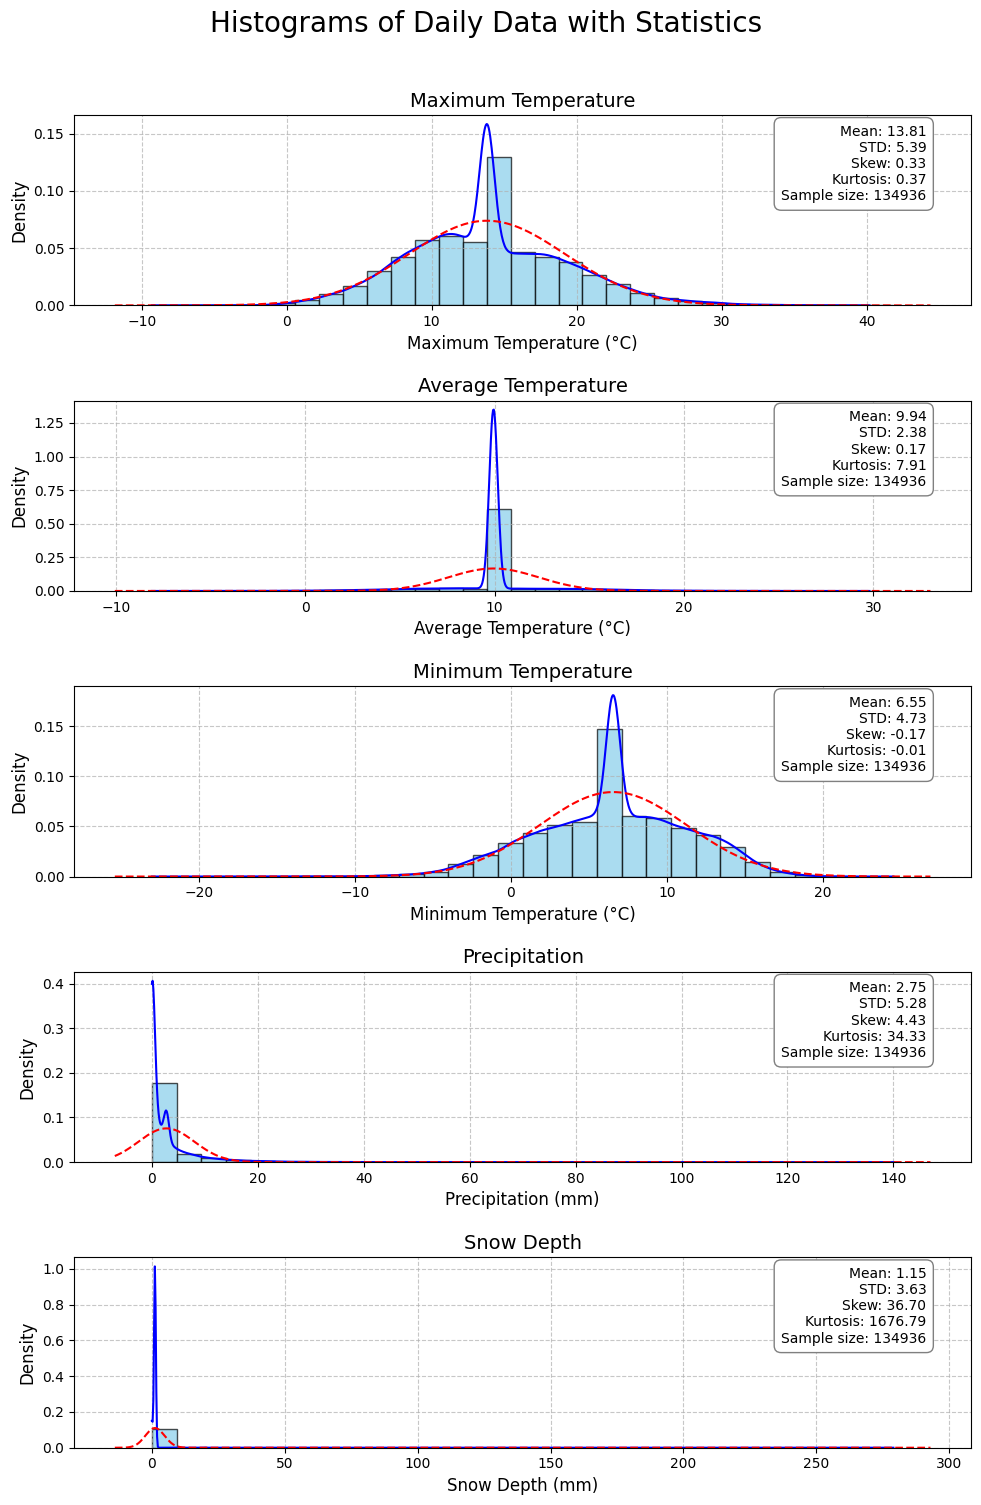

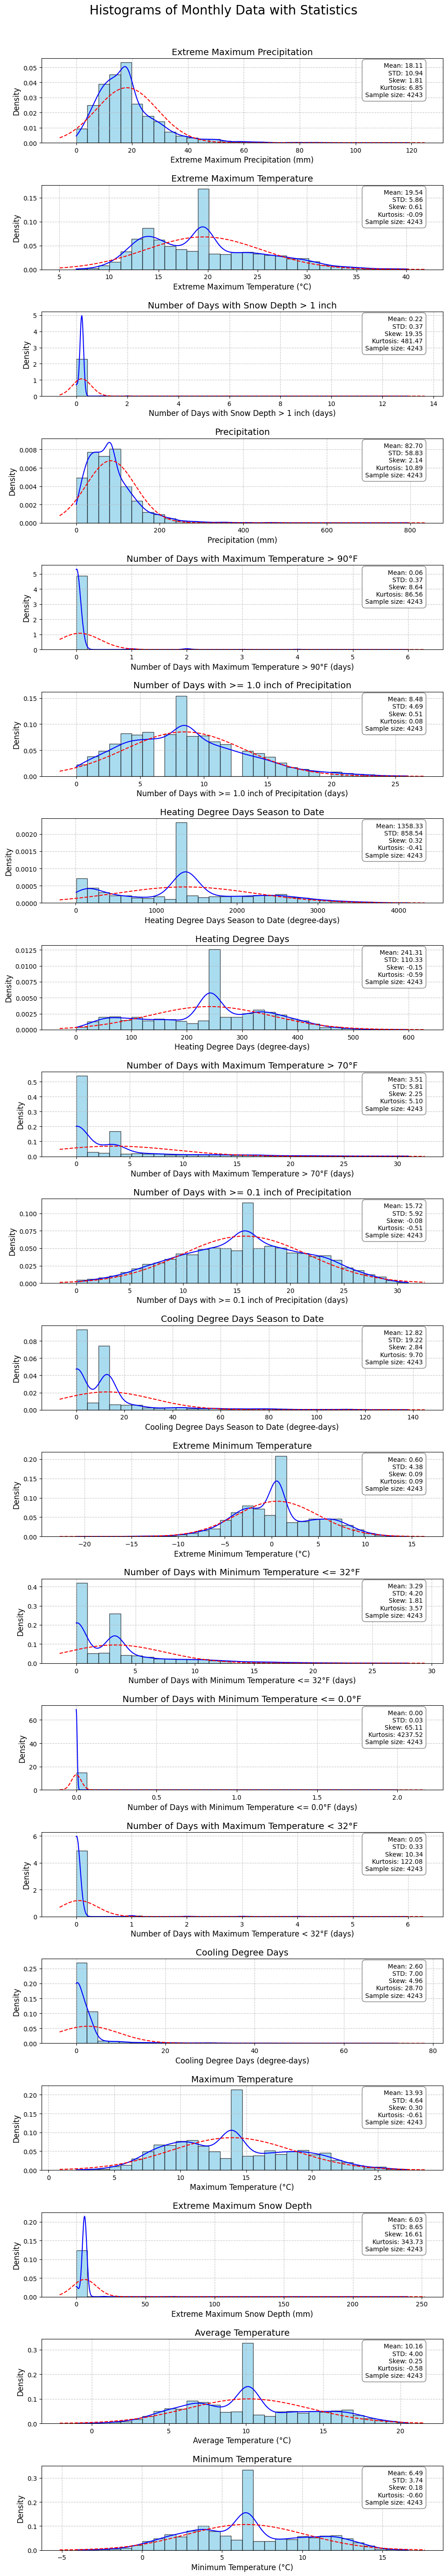

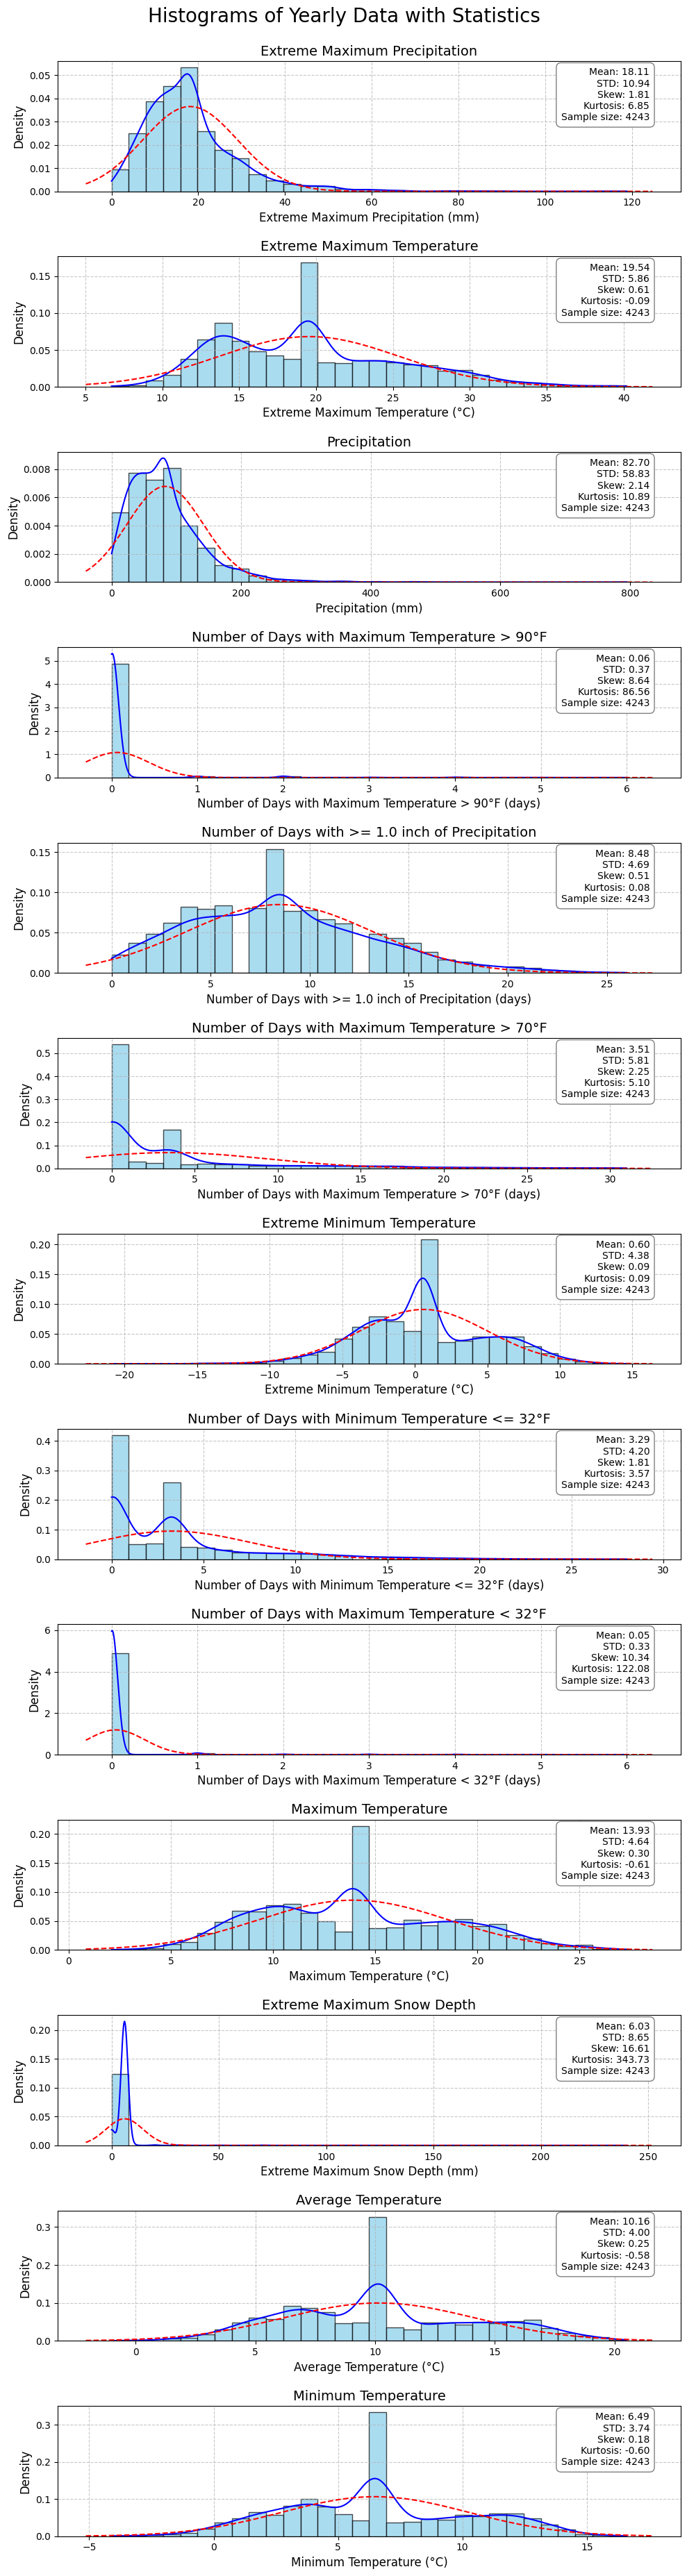

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, kurtosis, skew, norm

# Function to plot histograms with statistics
def plot_histograms_with_stats(df, name, cols, col_names, units, figsize, suptitle_y):
    num_rows = len(cols)
    fig, axes = plt.subplots(num_rows, 1, figsize=figsize, sharex=False)
    fig.suptitle(f'Histograms of {name} Data with Statistics', fontsize=20, y=suptitle_y)
    
    for i, (col, col_name, unit) in enumerate(zip(cols, col_names, units)):
        data = pd.to_numeric(df[col], errors='coerce').dropna()
        
        if not data.empty:
            ax = axes[i]
            
            # Histogram and KDE
            bin_width = (data.max() - data.min()) / 30  # Adjust the number of bins for better visualization
            bins = np.arange(data.min(), data.max() + bin_width, bin_width)
            ax.hist(data, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
            
            # Only compute KDE if there is more than one unique value
            if len(data.unique()) > 1:
                try:
                    kde = gaussian_kde(data)
                    x = np.linspace(data.min(), data.max(), 1000)
                    ax.plot(x, kde(x), color='blue')
                except Exception as e:
                    print(f"Skipping KDE for {col_name}: {e}")
            
            # Add bell curve (normal distribution)
            try:
                mean = data.mean()
                std_dev = data.std()
                xmin, xmax = ax.get_xlim()
                x = np.linspace(xmin, xmax, 1000)
                p = norm.pdf(x, mean, std_dev)
                ax.plot(x, p, color='red', linestyle='dashed')
            except Exception as e:
                print(f"Skipping normal distribution fit for {col_name}: {e}")
            
            # Calculate statistics
            try:
                mean = data.mean()
                std_dev = data.std()
                skewness = skew(data)
                kurt = kurtosis(data)
                sample_size = len(data)
                
                # Add statistics to the plot
                stats_text = (f'Mean: {mean:.2f}\n'
                              f'STD: {std_dev:.2f}\n'
                              f'Skew: {skewness:.2f}\n'
                              f'Kurtosis: {kurt:.2f}\n'
                              f'Sample size: {sample_size}')
                ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                        verticalalignment='top', horizontalalignment='right',
                        fontsize=10, bbox=dict(boxstyle='round,pad=0.5', edgecolor='gray', facecolor='white'))
            except Exception as e:
                print(f"Error calculating statistics for {col_name}: {e}")
            
            ax.set_title(col_name, fontsize=14)
            ax.set_ylabel('Density', fontsize=12)
            ax.set_xlabel(f'{col_name} ({unit})', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.7)
        else:
            ax.set_title(f"{col_name} - No Data Available")
            ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(top=0.93, hspace=0.5)
    plt.show()

# Plot histograms with statistics separately for each dataset
# Daily Data
daily_figsize = (10, len(COLUMNS['daily']) * 3)
plot_histograms_with_stats(daily_data, 'Daily', COLUMNS['daily'], COLUMN_NAMES['daily'], UNITS['daily'], daily_figsize, suptitle_y=1)

# Monthly Data
monthly_figsize = (10, len(COLUMNS['monthly']) * 3)
plot_histograms_with_stats(monthly_data, 'Monthly', COLUMNS['monthly'], COLUMN_NAMES['monthly'], UNITS['monthly'], monthly_figsize, suptitle_y=0.95)

# Yearly Data
yearly_figsize = (10, len(COLUMNS['yearly']) * 3)
plot_histograms_with_stats(yearly_data, 'Yearly', COLUMNS['yearly'], COLUMN_NAMES['yearly'], UNITS['yearly'], yearly_figsize, suptitle_y=0.95)


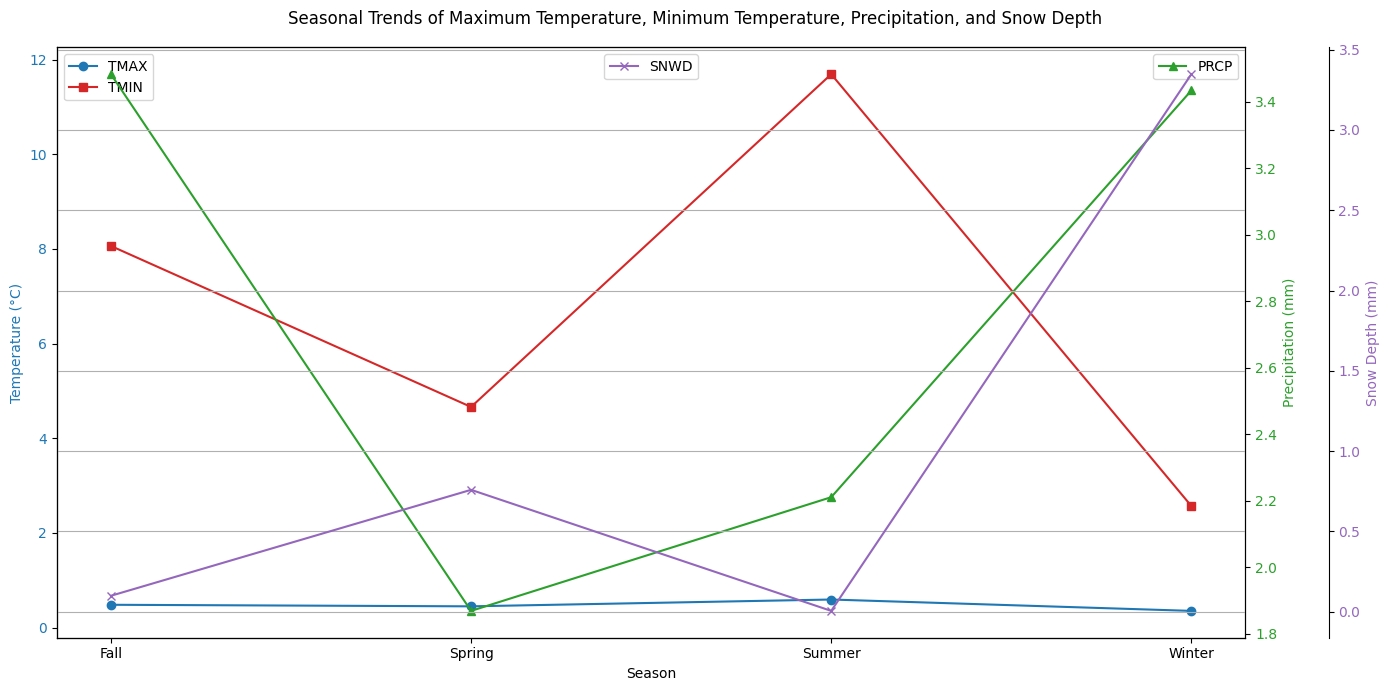

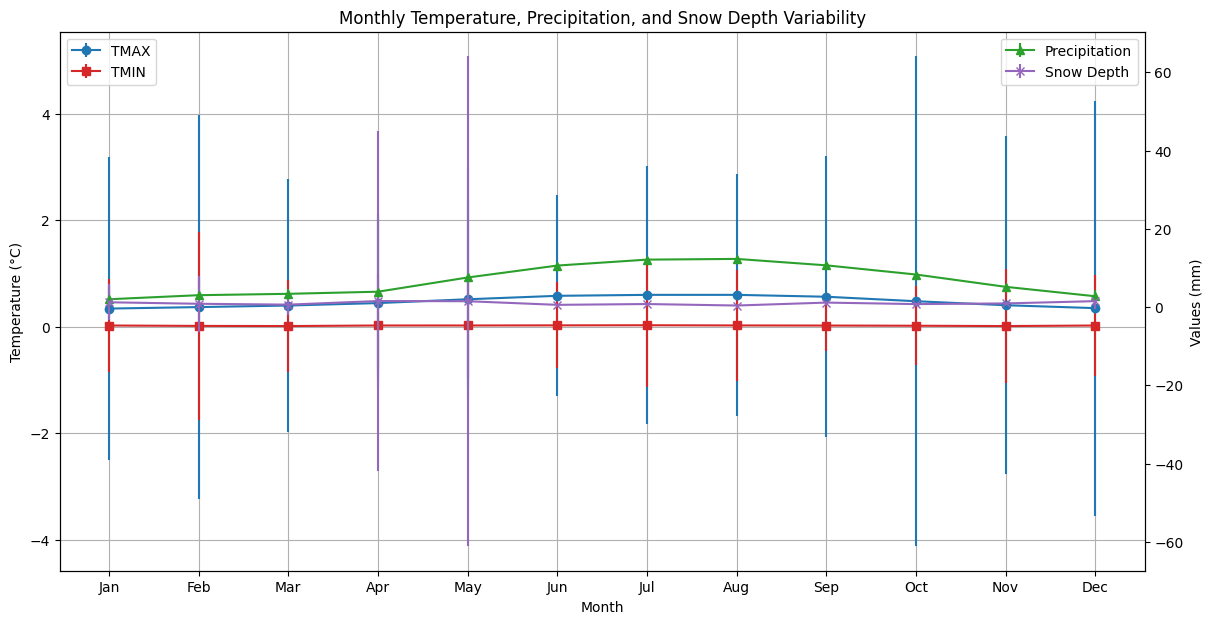

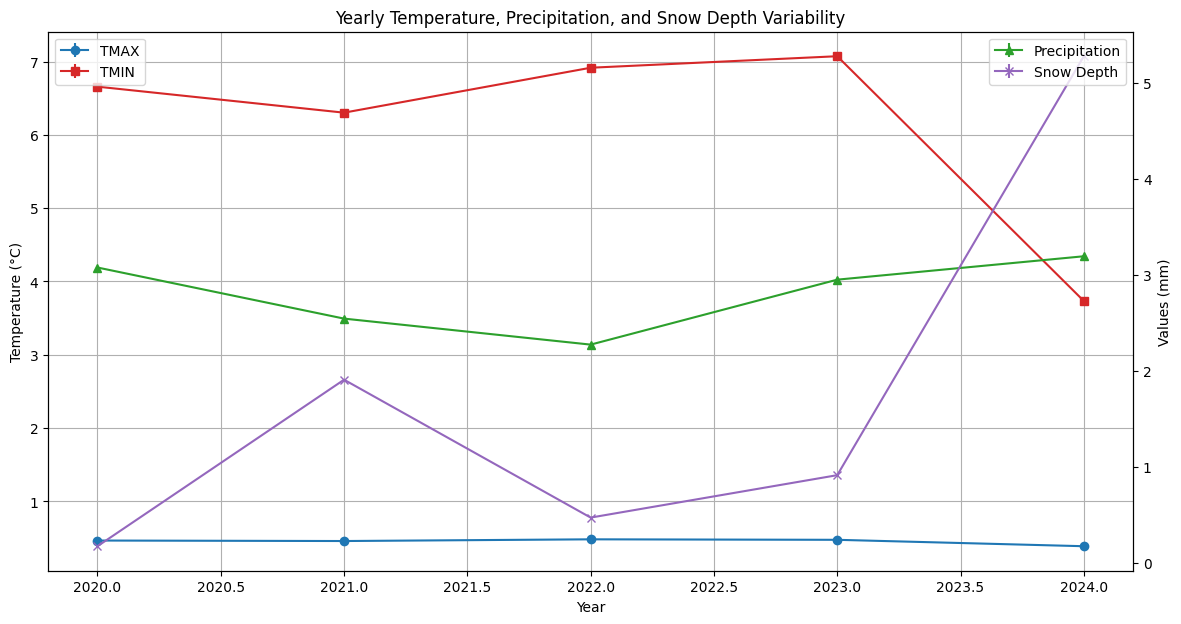

In [23]:
import matplotlib.pyplot as plt

# Function to categorize seasons
def categorize_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Add season column to daily data
daily_data['Season'] = daily_data.index.map(categorize_season)

# Select only numeric columns before aggregation
daily_data_numeric = daily_data.select_dtypes(include=[np.number])
daily_data_numeric['Season'] = daily_data['Season']

# Aggregate data by season
seasonal_data = daily_data_numeric.groupby('Season').mean()

# Function to plot seasonal trends
def plot_seasonal_trends(df, title):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    color1, color2, color3, color4 = 'tab:blue', 'tab:green', 'tab:red', 'tab:purple'

    ax1.set_xlabel('Season')
    ax1.set_ylabel('Temperature (°C)', color=color1)
    ax1.plot(df.index, df['TMAX'], color=color1, label='TMAX', marker='o')
    ax1.plot(df.index, df['TMIN'], color=color3, label='TMIN', marker='s')
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Precipitation (mm)', color=color2)
    ax2.plot(df.index, df['PRCP'], color=color2, label='PRCP', marker='^')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Check if 'SNWD' column exists before plotting
    if 'SNWD' in df.columns:
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))
        ax3.set_ylabel('Snow Depth (mm)', color=color4)
        ax3.plot(df.index, df['SNWD'], color=color4, label='SNWD', marker='x')
        ax3.tick_params(axis='y', labelcolor=color4)
        ax3.legend(loc='upper center')

    fig.suptitle(title)
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Plot seasonal trends
plot_seasonal_trends(seasonal_data, 'Seasonal Trends of Maximum Temperature, Minimum Temperature, Precipitation, and Snow Depth')

# Function to resample data and calculate statistics
def calculate_monthly_stats(df, columns):
    # Resample data to monthly data
    monthly_data = df[columns].resample('M').mean()
    
    # Extract month and year for grouping
    monthly_data['Year'] = monthly_data.index.year
    monthly_data['Month'] = monthly_data.index.month
    
    # Group by month and calculate mean and standard deviation
    monthly_stats = monthly_data.groupby('Month').agg({col: ['mean', 'std'] for col in columns})
    monthly_stats.columns = [f'{col}_mean' for col in columns] + [f'{col}_std' for col in columns]
    
    return monthly_stats

# Function to plot monthly variability for all parameters
def plot_combined_monthly_variability(stats, title):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    months = range(1, 13)
    ax1.errorbar(months, stats['TMAX_mean'], yerr=stats['TMAX_std'], fmt='-o', color='tab:blue', label='TMAX')
    ax1.errorbar(months, stats['TMIN_mean'], yerr=stats['TMIN_std'], fmt='-s', color='tab:red', label='TMIN')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.errorbar(months, stats['PRCP_mean'], yerr=stats['PRCP_std'], fmt='-^', color='tab:green', label='Precipitation')
    ax2.errorbar(months, stats['SNWD_mean'], yerr=stats['SNWD_std'], fmt='-x', color='tab:purple', label='Snow Depth')
    ax2.set_ylabel('Values (mm)')
    ax2.legend(loc='upper right')

    plt.xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.title(title)
    plt.show()

# Columns to analyze
columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD']
# Calculate monthly statistics
monthly_stats = calculate_monthly_stats(daily_data, columns)

# Plot combined monthly variability
plot_combined_monthly_variability(monthly_stats, 'Monthly Temperature, Precipitation, and Snow Depth Variability')

# Function to resample data and calculate yearly statistics
def calculate_yearly_stats(df, columns):
    # Resample data to yearly data
    yearly_data = df[columns].resample('Y').mean()
    
    # Extract year for grouping
    yearly_data['Year'] = yearly_data.index.year
    
    # Group by year and calculate mean and standard deviation
    yearly_stats = yearly_data.groupby('Year').agg(['mean', 'std'])
    yearly_stats.columns = ['_'.join(col) for col in yearly_stats.columns]
    
    return yearly_stats

# Function to plot yearly variability for all parameters
def plot_yearly_variability(stats, title):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    years = stats.index
    ax1.errorbar(years, stats['TMAX_mean'], yerr=stats['TMAX_std'], fmt='-o', color='tab:blue', label='TMAX')
    ax1.errorbar(years, stats['TMIN_mean'], yerr=stats['TMIN_std'], fmt='-s', color='tab:red', label='TMIN')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.errorbar(years, stats['PRCP_mean'], yerr=stats['PRCP_std'], fmt='-^', color='tab:green', label='Precipitation')
    ax2.errorbar(years, stats['SNWD_mean'], yerr=stats['SNWD_std'], fmt='-x', color='tab:purple', label='Snow Depth')
    ax2.set_ylabel('Values (mm)')
    ax2.legend(loc='upper right')

    plt.title(title)
    plt.show()

# Columns to analyze
columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD']
# Calculate yearly statistics
yearly_stats = calculate_yearly_stats(daily_data, columns)

# Plot yearly variability
plot_yearly_variability(yearly_stats, 'Yearly Temperature, Precipitation, and Snow Depth Variability')


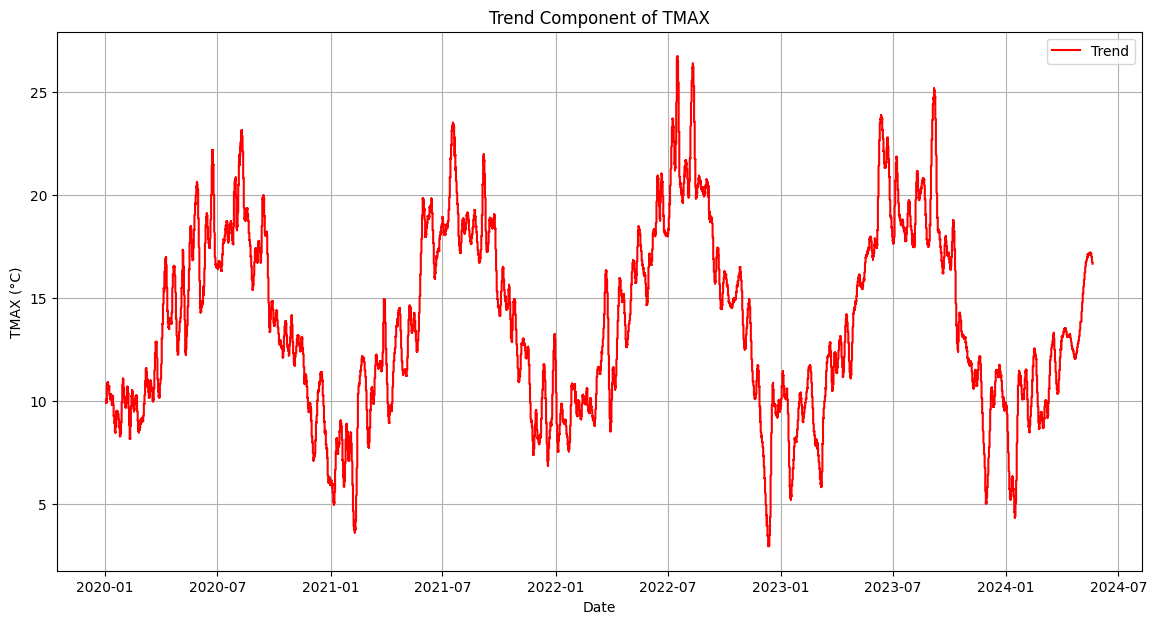

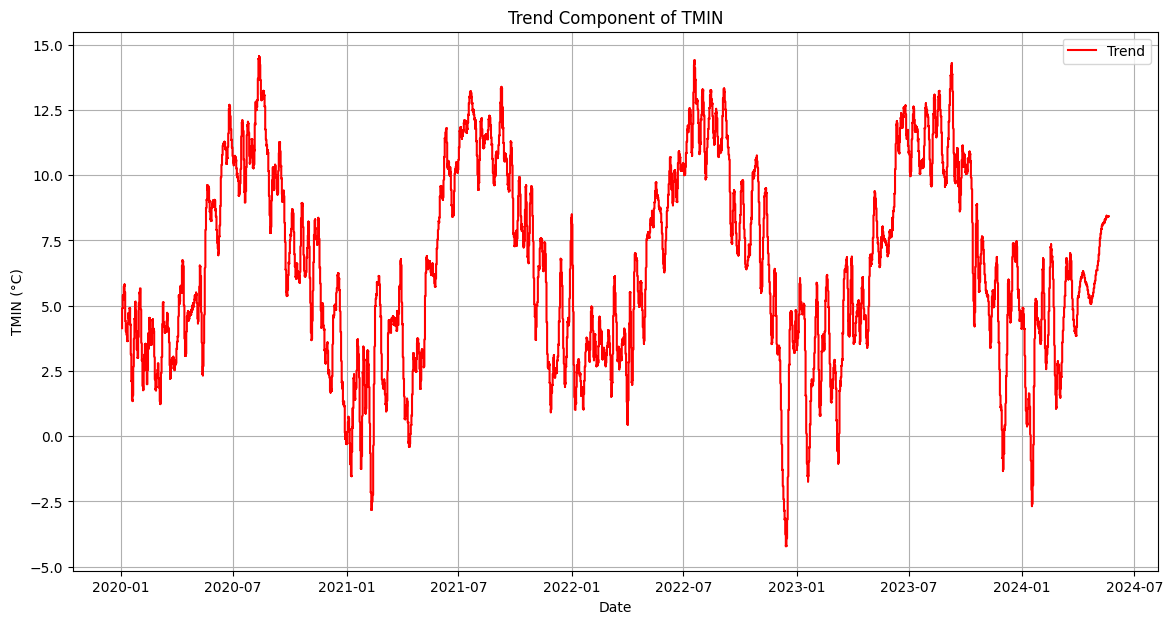

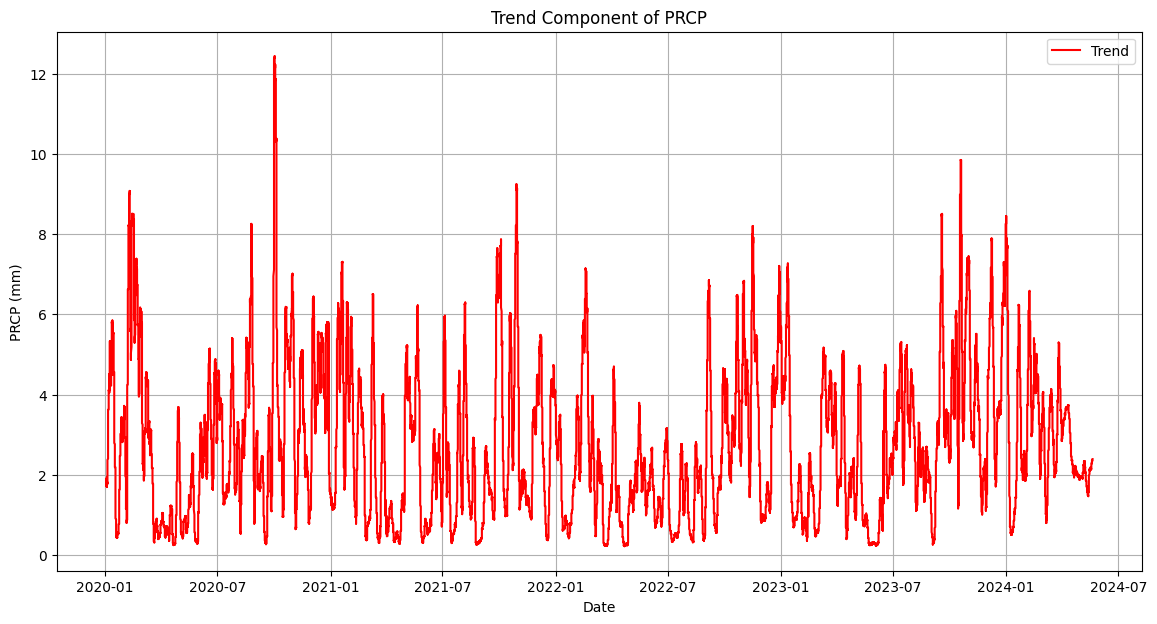

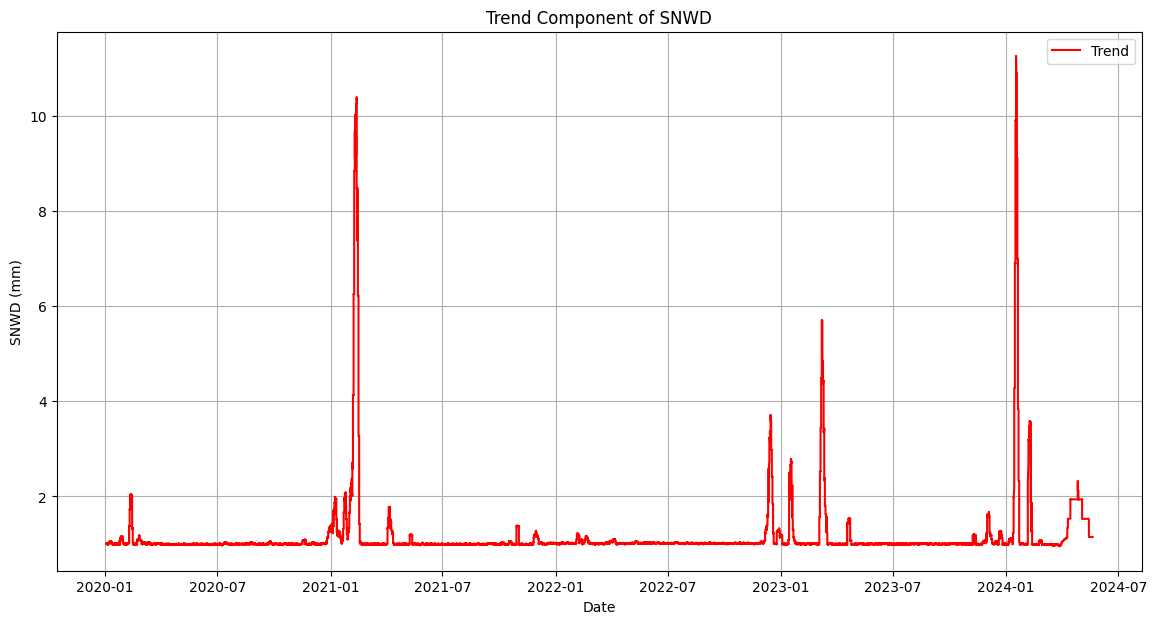

In [7]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to plot seasonal decomposition
def plot_seasonal_decomposition(df, column, period=365, units='units'):
    result = seasonal_decompose(df[column], model='additive', period=period)
    plt.figure(figsize=(14, 7))
    plt.plot(result.trend, label='Trend', color='red')
    plt.title(f'Trend Component of {column}')
    plt.xlabel('Date')
    plt.ylabel(f'{column} ({units})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Units dictionary for daily data
UNITS = {
    'TMAX': '°C',
    'TMIN': '°C',
    'PRCP': 'mm',
    'SNWD': 'mm'
}

# Perform and plot seasonal decomposition for each parameter except 'TAVG'
for col in COLUMNS['daily']:
    if col != 'TAVG':
        plot_seasonal_decomposition(daily_data, col, units=UNITS.get(col, 'units'))


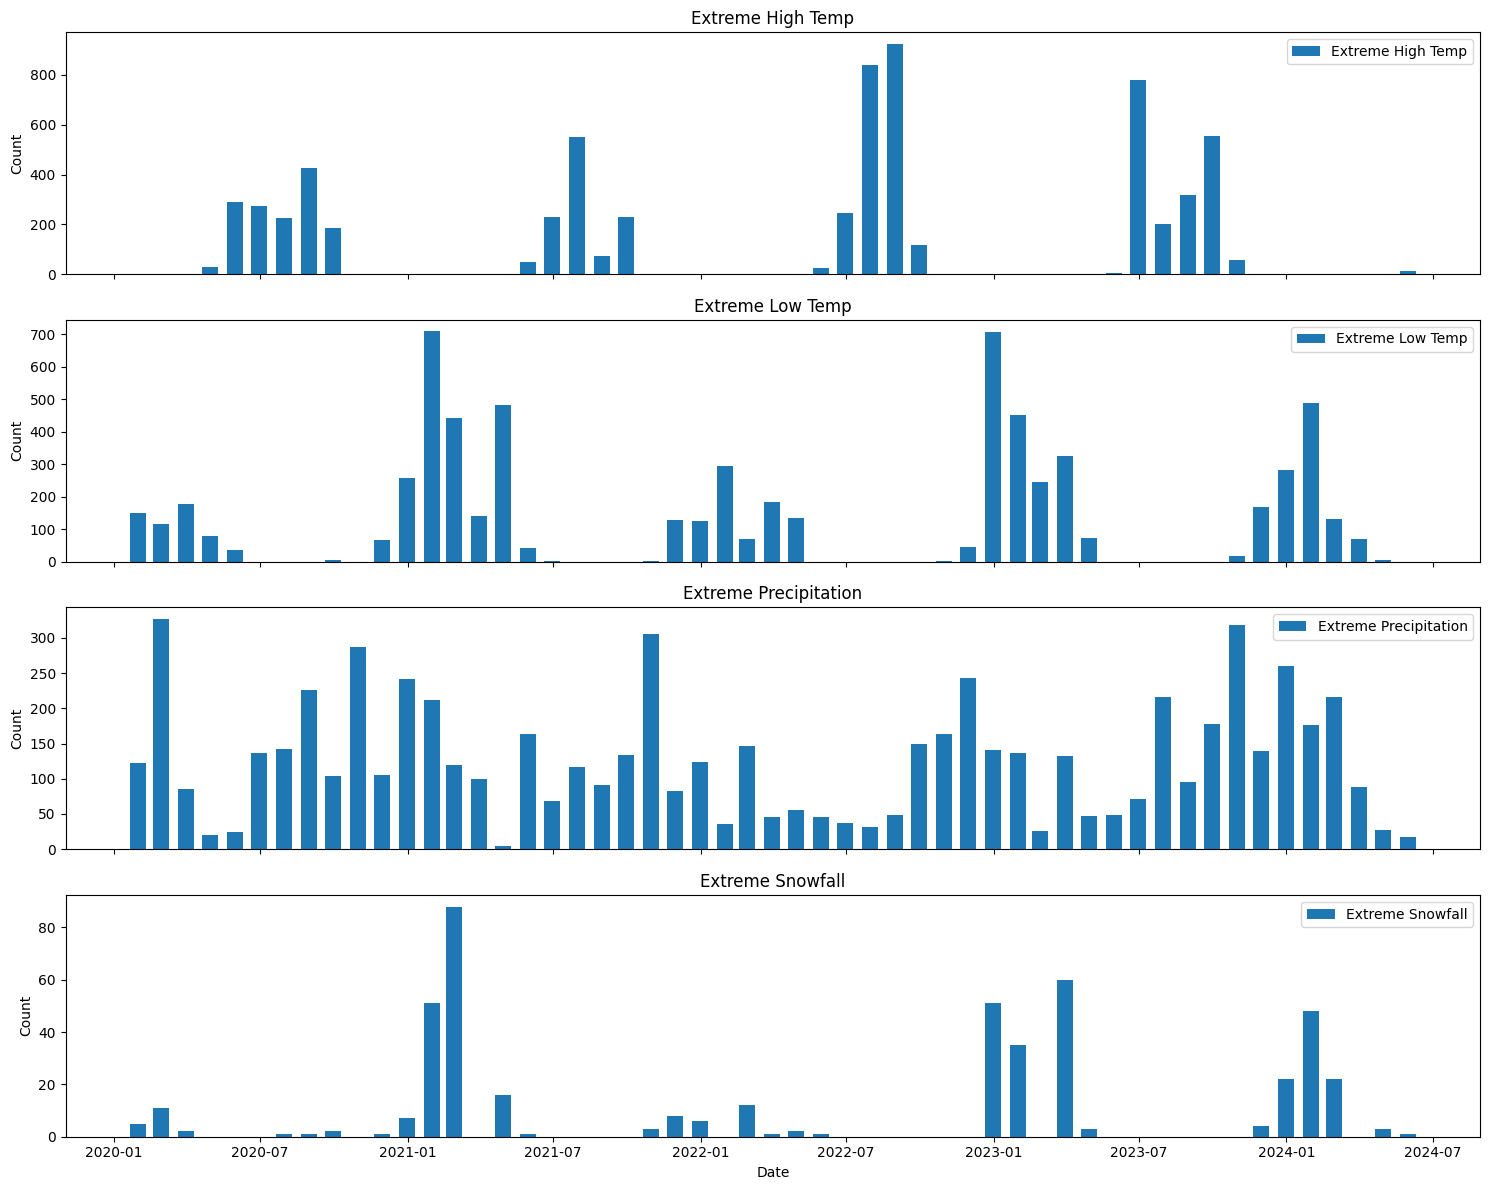

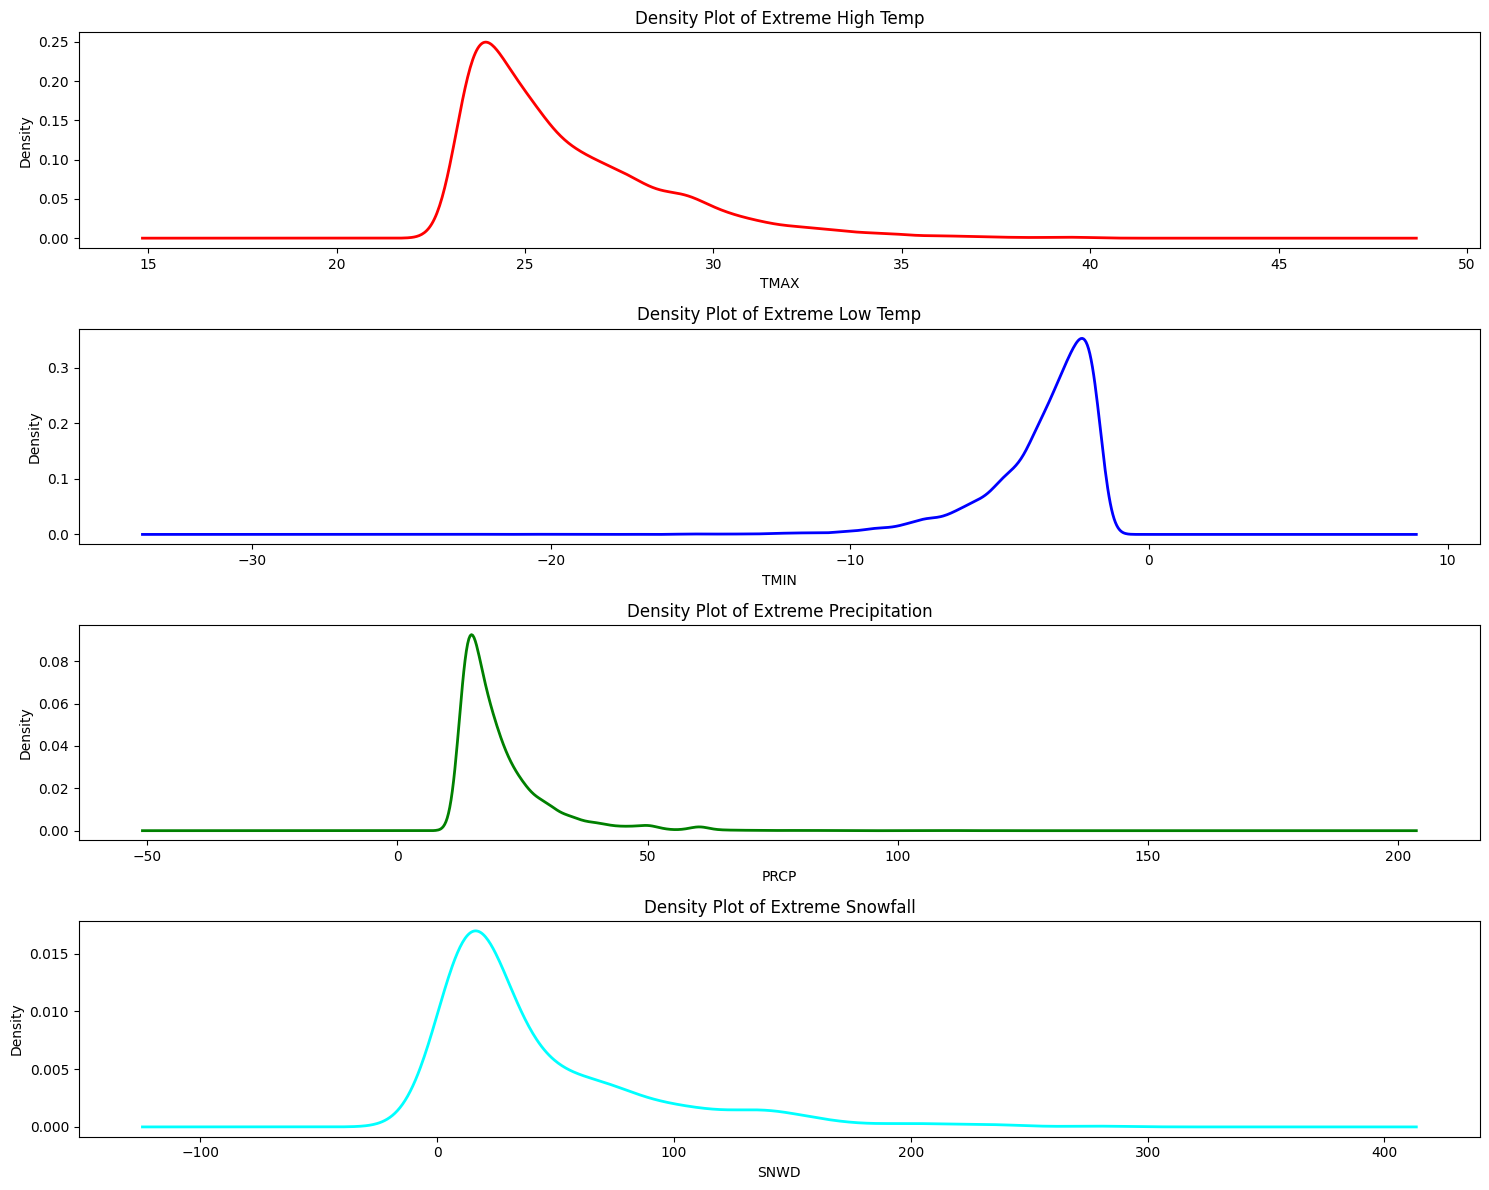

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Select specific columns
selected_columns = ['TMIN', 'TMAX', 'PRCP', 'SNWD']
filtered_data = daily_data[selected_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean for selected columns
for column in selected_columns:
    filtered_data[column].fillna(filtered_data[column].mean(), inplace=True)

# Calculate the 95th and 5th percentiles for each variable
percentiles = filtered_data.quantile([0.05, 0.95])

# Identify extreme events
extreme_events = {
    'Extreme High Temp': filtered_data['TMAX'] > percentiles.loc[0.95, 'TMAX'],
    'Extreme Low Temp': filtered_data['TMIN'] < percentiles.loc[0.05, 'TMIN'],
    'Extreme Precipitation': filtered_data['PRCP'] > percentiles.loc[0.95, 'PRCP'],
    'Extreme Snowfall': filtered_data['SNWD'] > percentiles.loc[0.95, 'SNWD'],
}

# Convert to DataFrame
extreme_events_df = pd.DataFrame(extreme_events)

# Create bar plots for extreme events over time
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 12), sharex=True)

for ax, (event, data) in zip(axes, extreme_events_df.items()):
    monthly_counts = data.resample('M').sum()
    ax.bar(monthly_counts.index, monthly_counts, width=20, align='center', label=event)
    ax.set_title(event)
    ax.set_ylabel('Count')
    ax.legend()

axes[-1].set_xlabel('Date')  # Set x-axis label for the last subplot

fig.tight_layout()
plt.show()

# Create density plots (KDE) for histograms of extreme events
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

for ax, (event, data) in zip(axes, extreme_events_df.items()):
    if 'High' in event:
        column = 'TMAX'
        color = 'red'
    elif 'Low' in event:
        column = 'TMIN'
        color = 'blue'
    elif 'Precipitation' in event:
        column = 'PRCP'
        color = 'green'
    elif 'Snowfall' in event:
        column = 'SNWD'
        color = 'cyan'
    
    extreme_values = filtered_data[column][data]
    extreme_values.plot(kind='kde', ax=ax, color=color, linewidth=2)
    ax.set_title(f'Density Plot of {event}')
    ax.set_xlabel(column)  # Set x-axis label for each subplot
    ax.set_ylabel('Density')

fig.tight_layout()
plt.show()


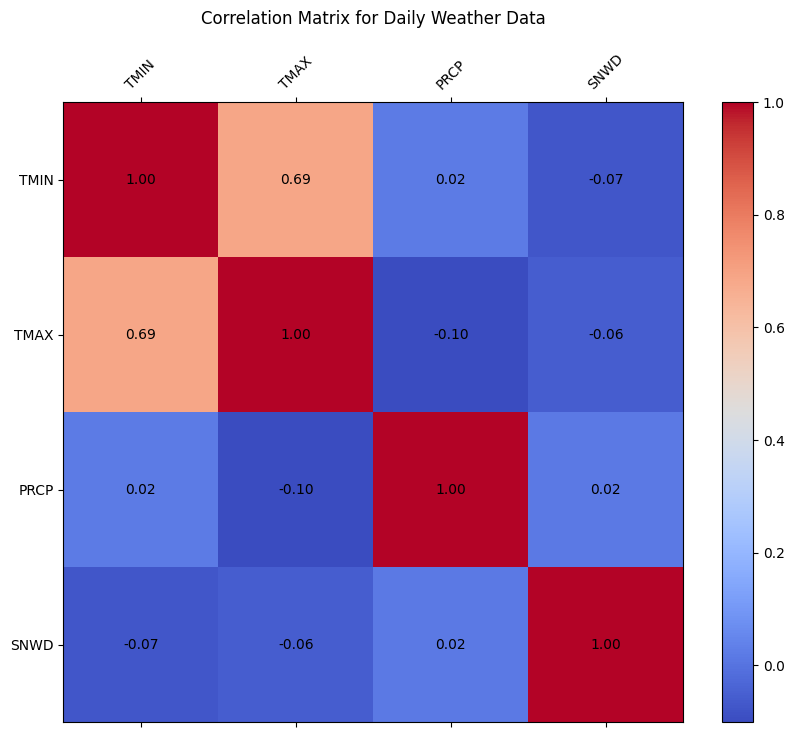

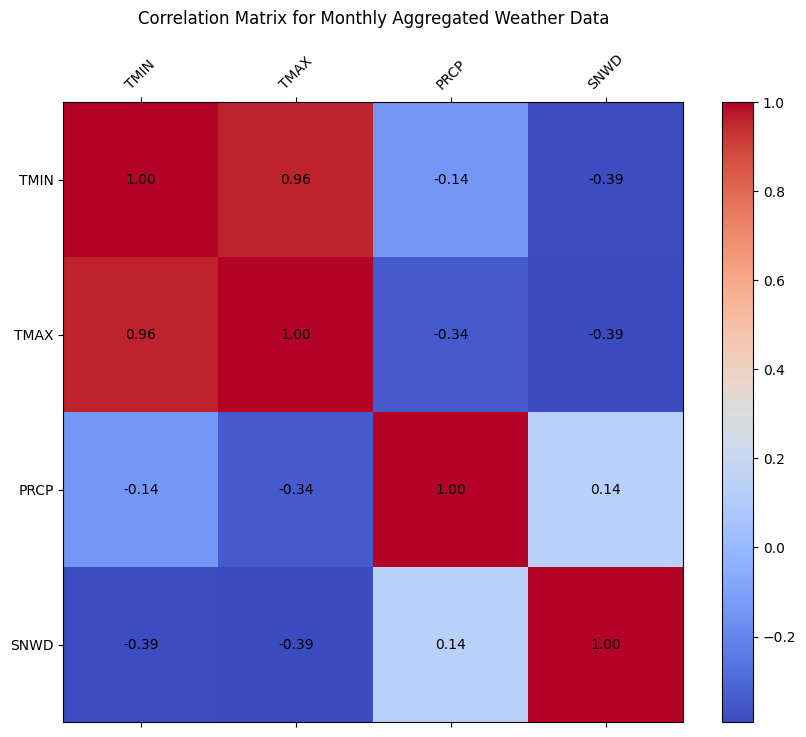

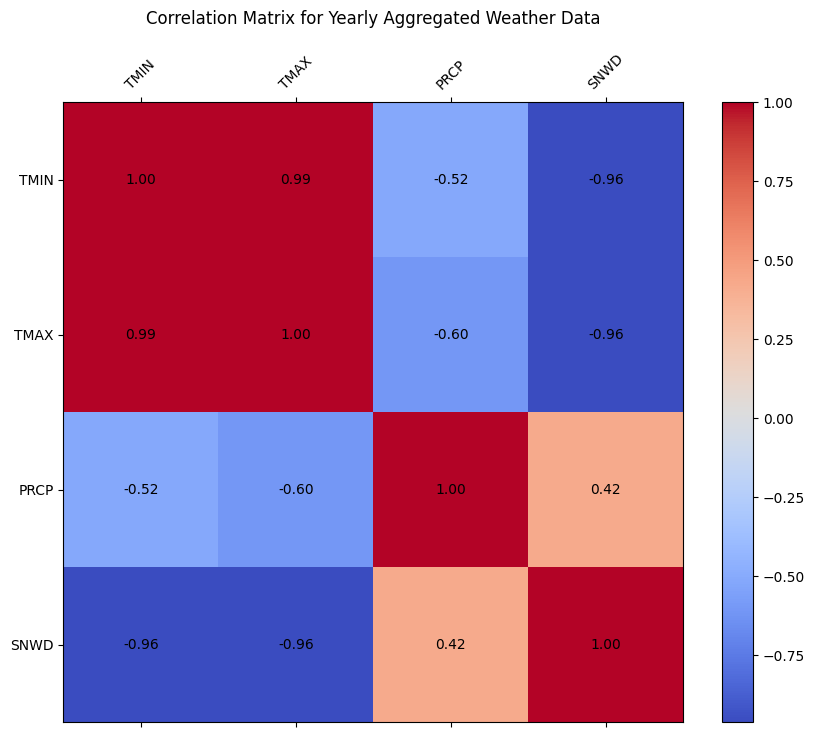

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming daily_data is already loaded and preprocessed
# Select specific columns
selected_columns = ['TMIN', 'TMAX', 'PRCP', 'SNWD']
filtered_data = daily_data[selected_columns]

# Ensure columns exist in the DataFrame
filtered_data = filtered_data.dropna()

# Aggregate data by month
monthly_aggregated_data = filtered_data.resample('M').mean()

# Aggregate data by year
yearly_aggregated_data = filtered_data.resample('Y').mean()

def plot_correlation_matrix(data, title):
    # Calculate correlation matrix
    correlation_matrix = data.corr()

    # Plot the correlation matrix with values
    plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
    plt.colorbar()

    # Display the correlation values in the matrix
    for (i, j), val in np.ndenumerate(correlation_matrix.values):
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

    # Add labels
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
    plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
    plt.title(title, pad=20)
    plt.show()

# Plot correlation matrix for daily data
plot_correlation_matrix(filtered_data, 'Correlation Matrix for Daily Weather Data')

# Plot correlation matrix for monthly aggregated data
plot_correlation_matrix(monthly_aggregated_data, 'Correlation Matrix for Monthly Aggregated Weather Data')

# Plot correlation matrix for yearly aggregated data
plot_correlation_matrix(yearly_aggregated_data, 'Correlation Matrix for Yearly Aggregated Weather Data')


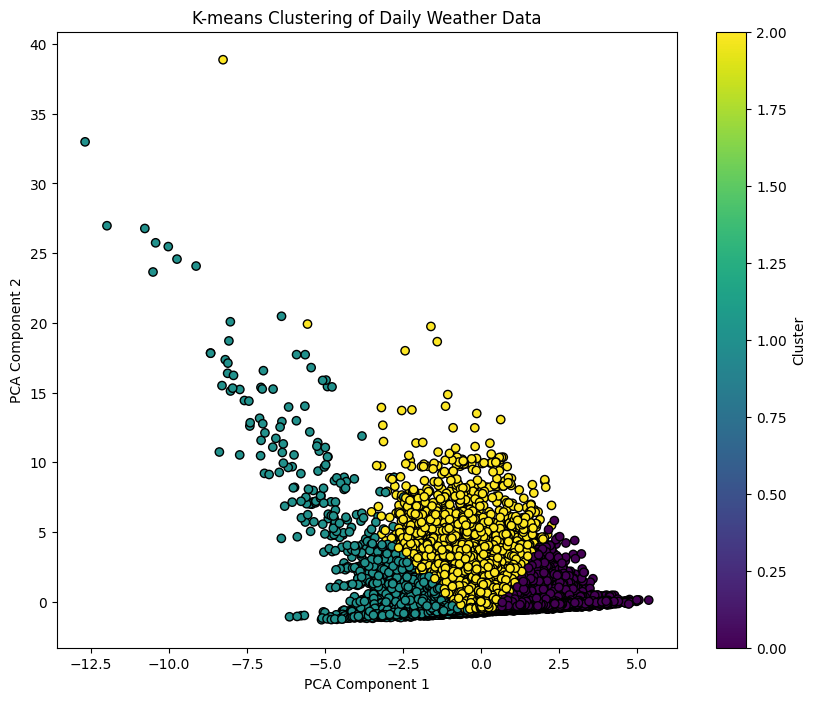

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare the data
X = daily_data[['TMAX', 'TMIN', 'PRCP', 'SNWD']].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for visualization purposes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')
plt.title('K-means Clustering of Daily Weather Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


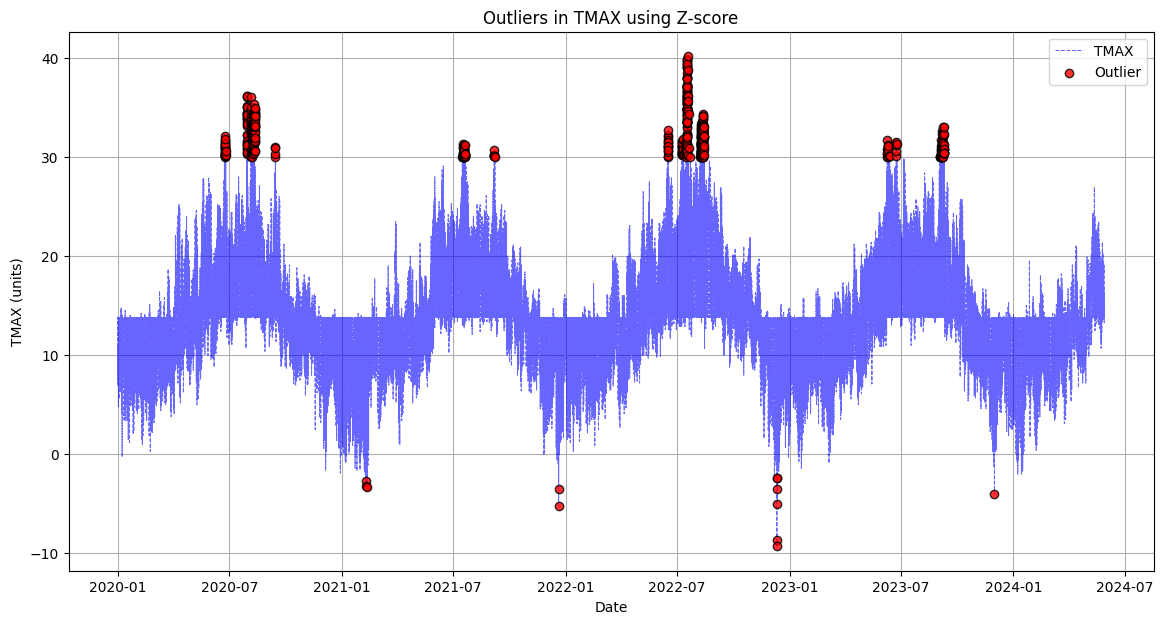

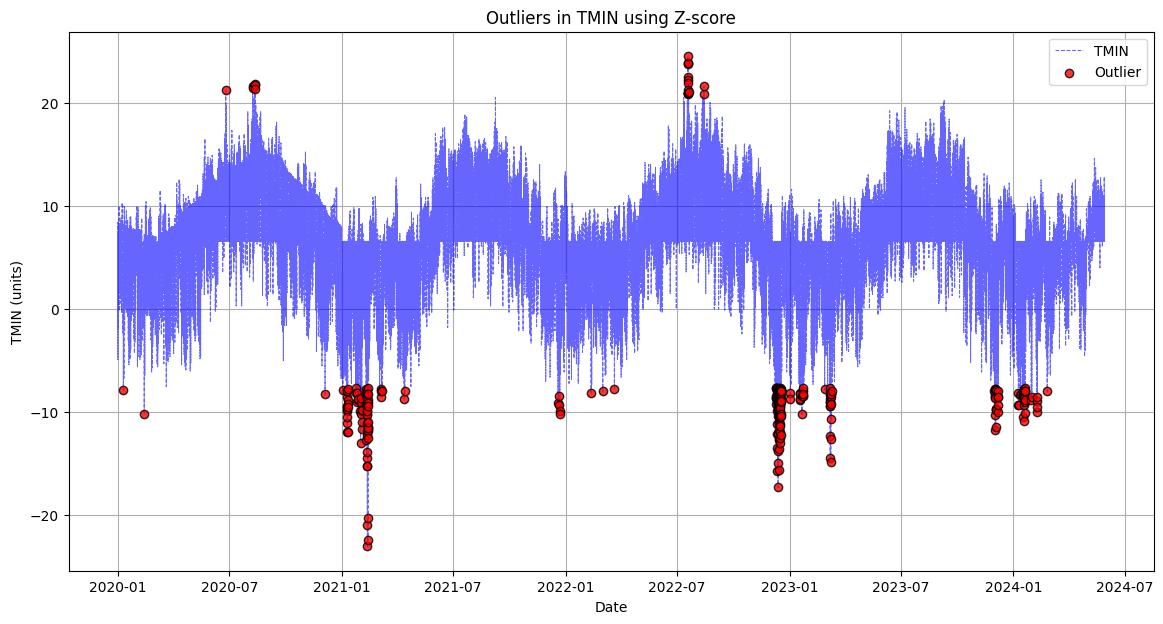

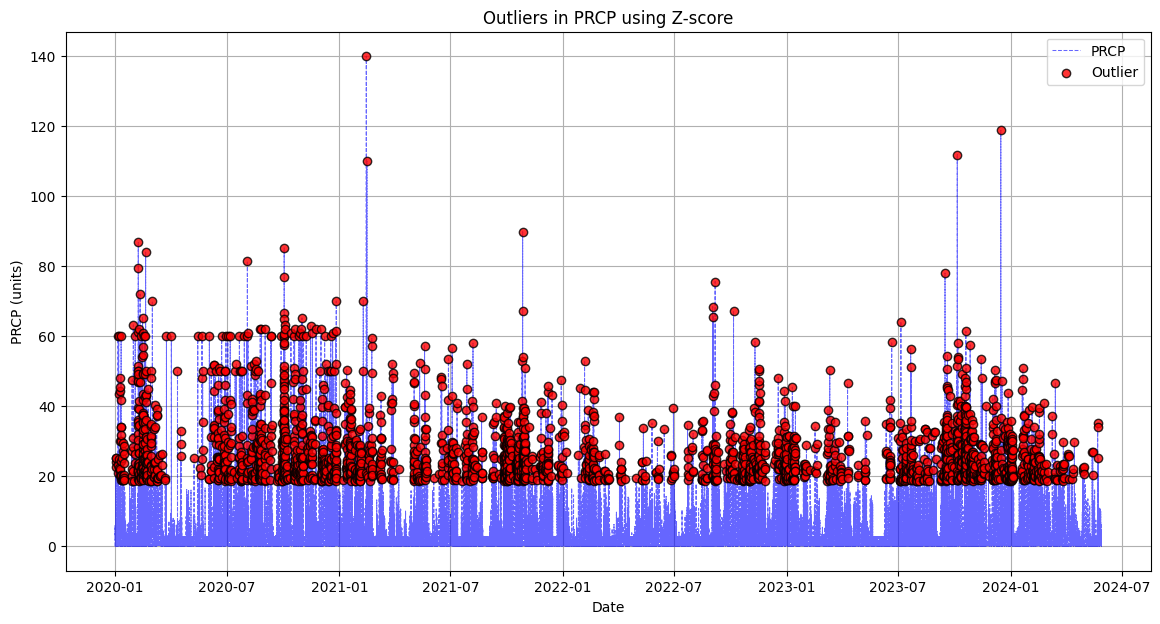

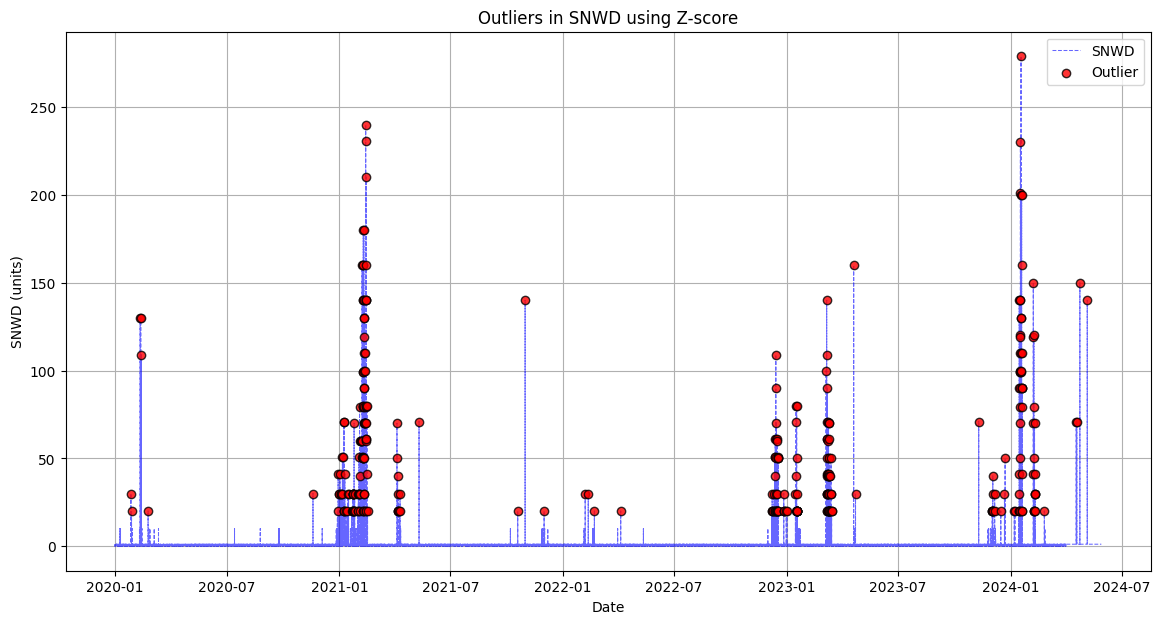

Column: TMAX
Number of Outliers: 611
Mean of Outliers: 31.49
Standard Deviation of Outliers: 5.51
Minimum Outlier Value: -9.30
Maximum Outlier Value: 40.20


Column: TMIN
Number of Outliers: 296
Mean of Outliers: -7.29
Standard Deviation of Outliers: 8.56
Minimum Outlier Value: -23.00
Maximum Outlier Value: 24.50


Column: PRCP
Number of Outliers: 2982
Mean of Outliers: 27.47
Standard Deviation of Outliers: 10.45
Minimum Outlier Value: 18.60
Maximum Outlier Value: 140.00


Column: SNWD
Number of Outliers: 312
Mean of Outliers: 58.88
Standard Deviation of Outliers: 47.60
Minimum Outlier Value: 20.00
Maximum Outlier Value: 279.00




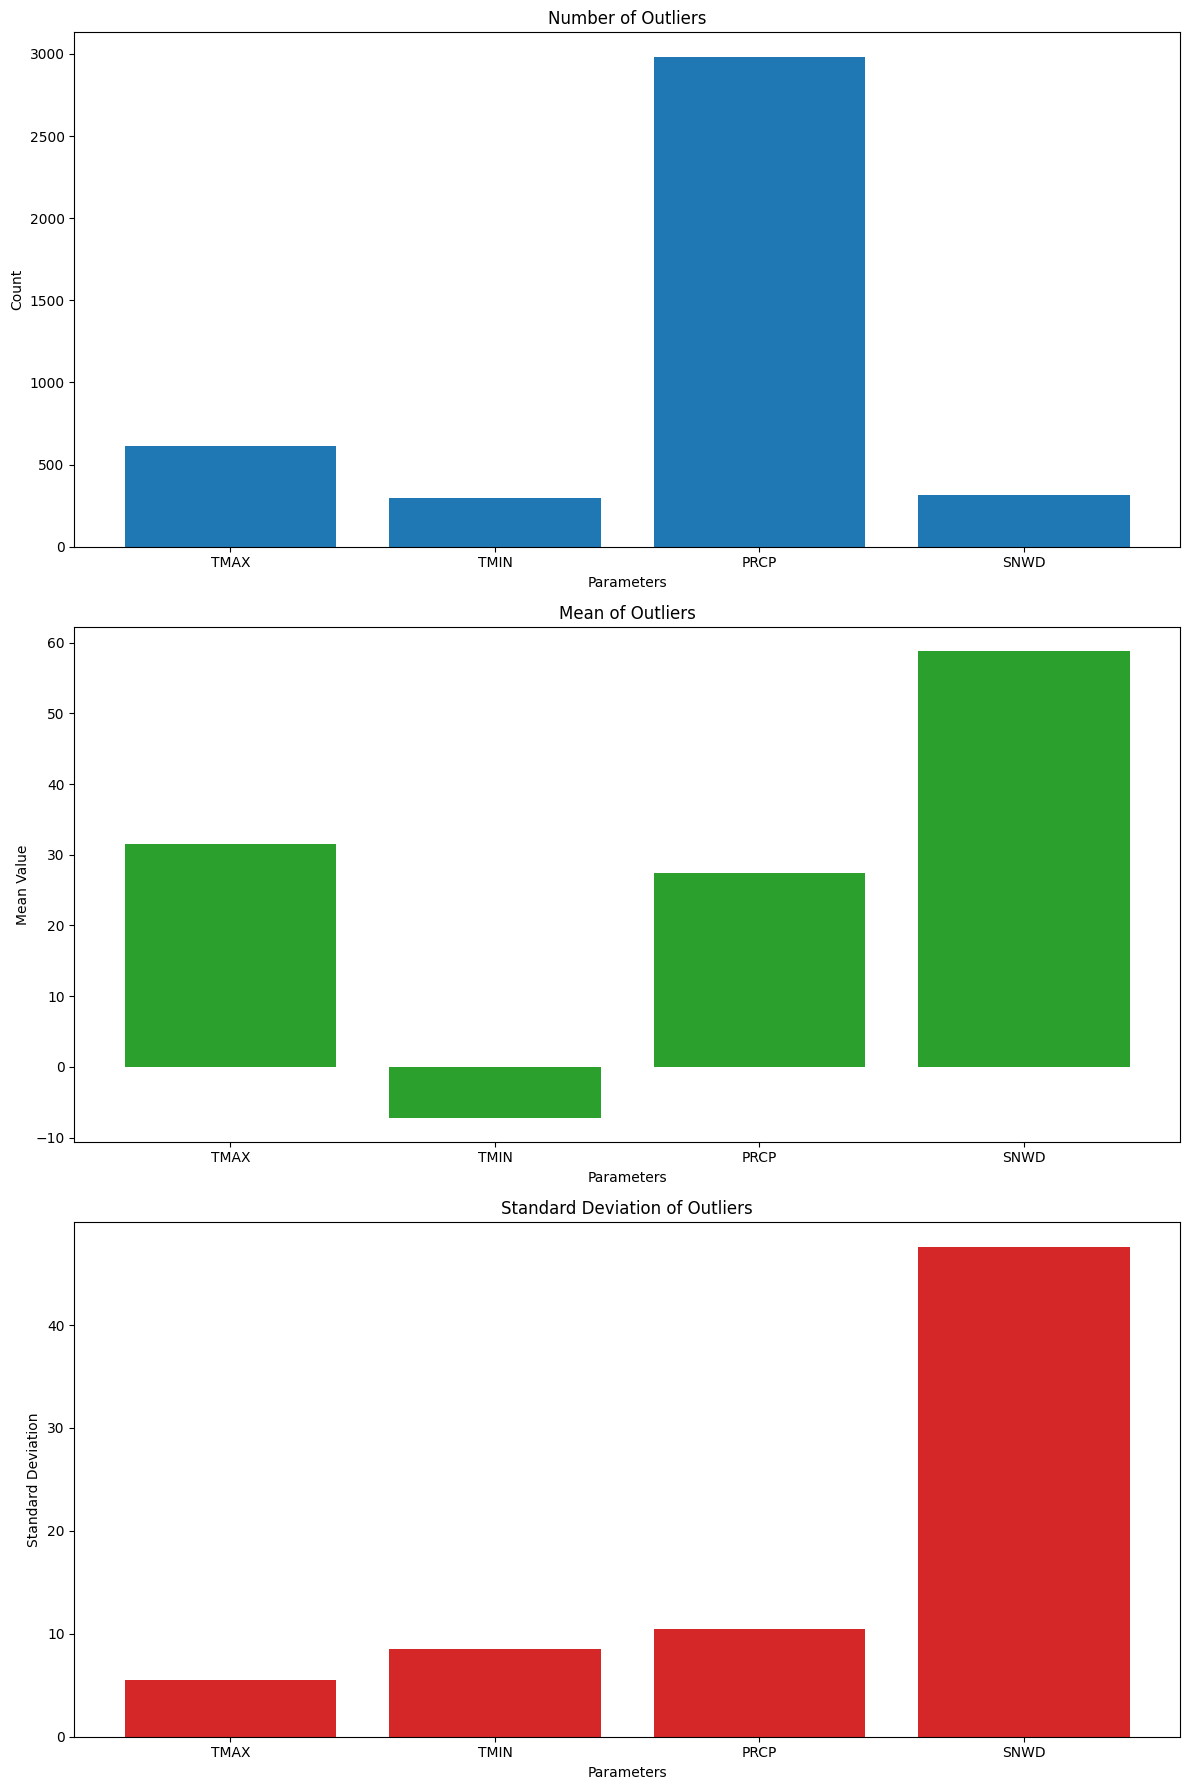

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Function to calculate Z-scores
def calculate_z_scores(df, column):
    df['Z_score'] = zscore(df[column])
    return df

# Function to detect outliers using Z-scores
def detect_outliers_z_score(df, column, threshold=3):
    df = calculate_z_scores(df, column)
    outliers = df[(df['Z_score'].abs() > threshold)]
    return outliers

# Function to plot outliers using Z-scores
def plot_outliers_z_score(df, outliers, column, title, y_label):
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(df.index, df[column], label=column, color='blue', linestyle='--', linewidth=0.75, alpha=0.6)
    ax.scatter(outliers.index, outliers[column], color='red', label='Outlier', edgecolor='k', zorder=5, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(True)
    plt.show()

# Columns to analyze
columns = ['TMAX', 'TMIN', 'PRCP', 'SNWD']

# Detect and plot outliers using Z-scores for each column
for column in columns:
    outliers = detect_outliers_z_score(daily_data, column)
    plot_outliers_z_score(daily_data, outliers, column, f'Outliers in {column} using Z-score', f'{column} (units)')

# Function to generate summary of outliers
def summarize_outliers(df, outliers, column):
    summary = {
        'column': column,
        'num_outliers': len(outliers),
        'mean_outliers': outliers[column].mean(),
        'std_outliers': outliers[column].std(),
        'min_outlier': outliers[column].min(),
        'max_outlier': outliers[column].max(),
    }
    return summary

# Function to print summary in a readable format
def print_outlier_summary(summary):
    print(f"Column: {summary['column']}")
    print(f"Number of Outliers: {summary['num_outliers']}")
    print(f"Mean of Outliers: {summary['mean_outliers']:.2f}")
    print(f"Standard Deviation of Outliers: {summary['std_outliers']:.2f}")
    print(f"Minimum Outlier Value: {summary['min_outlier']:.2f}")
    print(f"Maximum Outlier Value: {summary['max_outlier']:.2f}")
    print("\n")
    
# Function to visualize outlier summary using bar charts
def visualize_outlier_summary(summaries):
    columns = [summary['column'] for summary in summaries]
    num_outliers = [summary['num_outliers'] for summary in summaries]
    mean_outliers = [summary['mean_outliers'] for summary in summaries]
    std_outliers = [summary['std_outliers'] for summary in summaries]

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Number of Outliers
    axs[0].bar(columns, num_outliers, color='tab:blue')
    axs[0].set_title('Number of Outliers')
    axs[0].set_xlabel('Parameters')
    axs[0].set_ylabel('Count')

    # Mean of Outliers
    axs[1].bar(columns, mean_outliers, color='tab:green')
    axs[1].set_title('Mean of Outliers')
    axs[1].set_xlabel('Parameters')
    axs[1].set_ylabel('Mean Value')

    # Standard Deviation of Outliers
    axs[2].bar(columns, std_outliers, color='tab:red')
    axs[2].set_title('Standard Deviation of Outliers')
    axs[2].set_xlabel('Parameters')
    axs[2].set_ylabel('Standard Deviation')

    plt.tight_layout()
    plt.show()

# Detect, summarize, and display outliers for each column
outlier_summaries = []

for column in columns:
    outliers = detect_outliers_z_score(daily_data, column)
    summary = summarize_outliers(daily_data, outliers, column)
    outlier_summaries.append(summary)
    print_outlier_summary(summary)

# Visualize the outlier summary
visualize_outlier_summary(outlier_summaries)


Data loaded and preprocessed successfully.


00:25:06 - cmdstanpy - INFO - Chain [1] start processing
00:25:42 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet RMSE: 0.6381113292827358


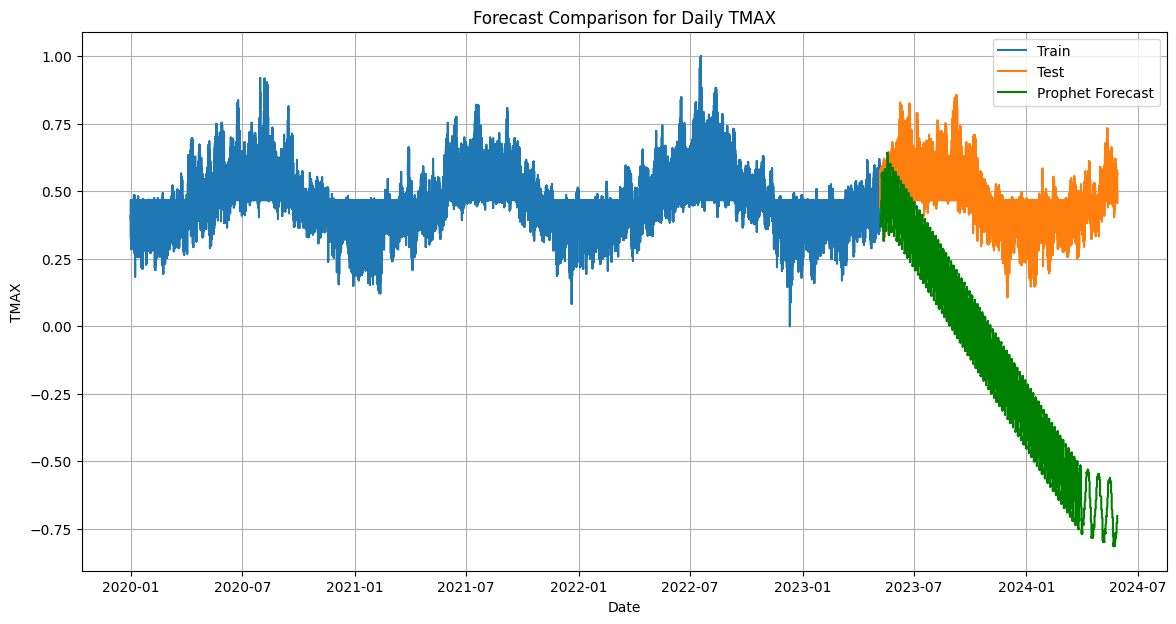

00:25:50 - cmdstanpy - INFO - Chain [1] start processing
00:26:25 - cmdstanpy - INFO - Chain [1] done processing


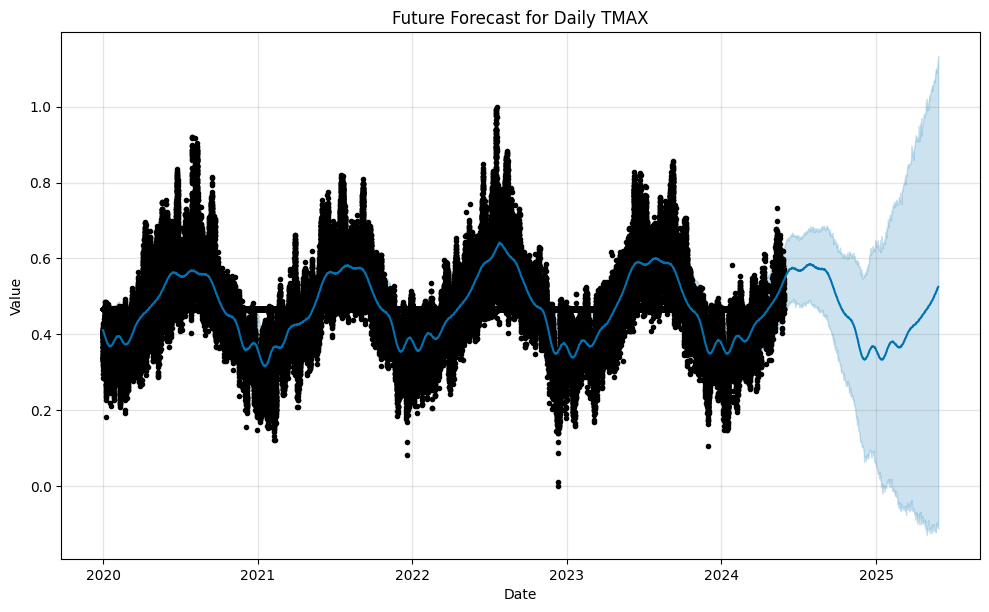

00:26:26 - cmdstanpy - INFO - Chain [1] start processing
00:26:26 - cmdstanpy - INFO - Chain [1] done processing


Monthly Prophet RMSE: 0.32364715513665626


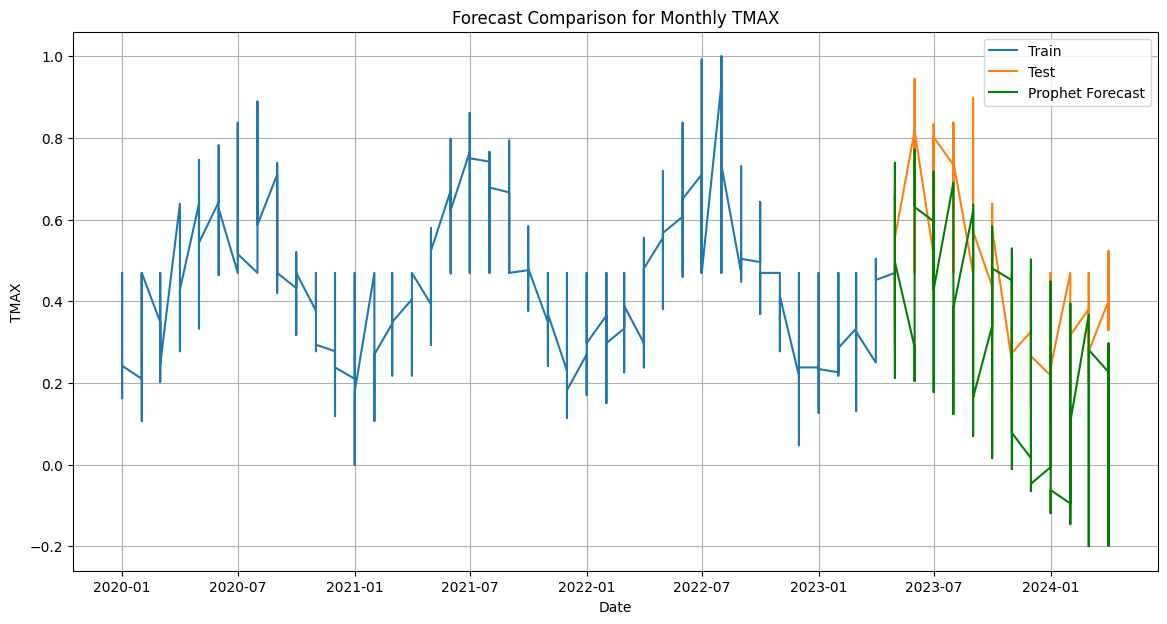

00:26:26 - cmdstanpy - INFO - Chain [1] start processing
00:26:26 - cmdstanpy - INFO - Chain [1] done processing


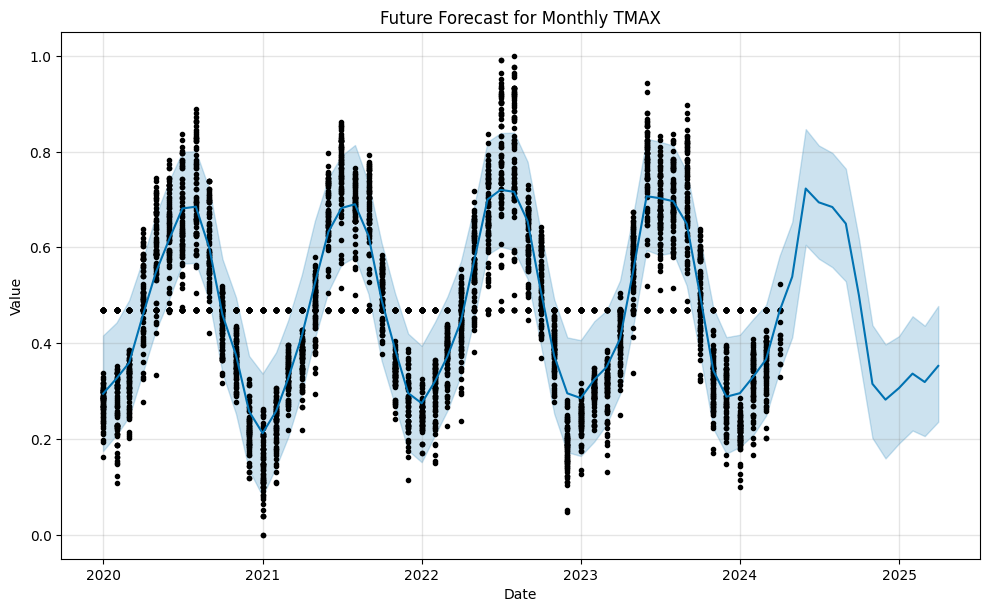

00:26:27 - cmdstanpy - INFO - Chain [1] start processing
00:26:27 - cmdstanpy - INFO - Chain [1] done processing


Yearly Prophet RMSE: 0.19182321359986987


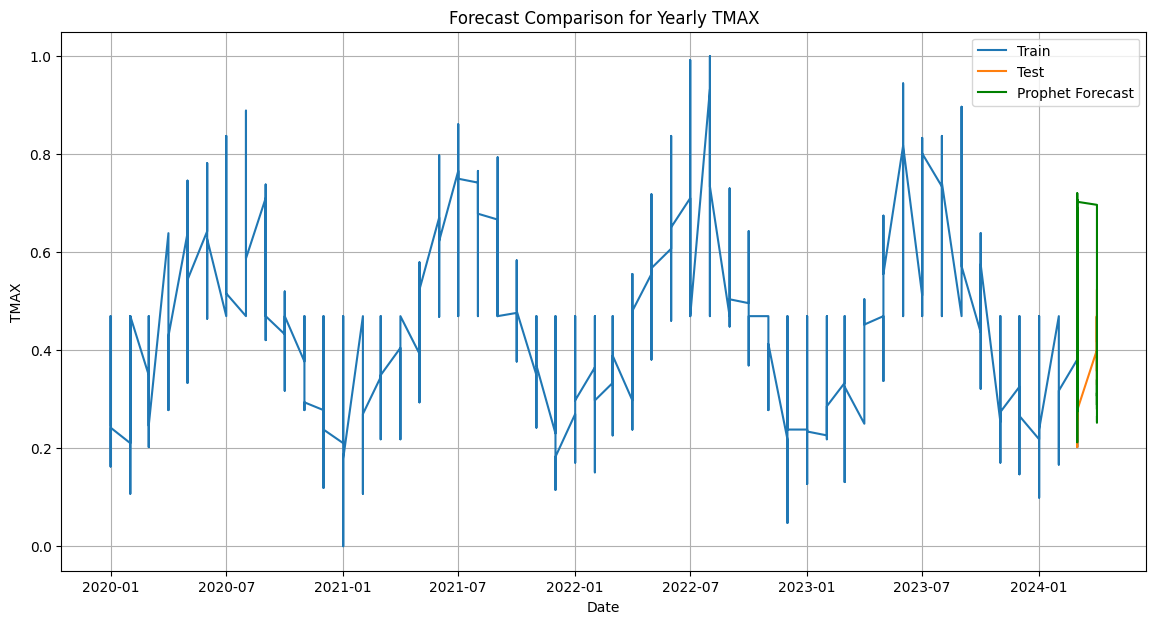

00:26:27 - cmdstanpy - INFO - Chain [1] start processing
00:26:27 - cmdstanpy - INFO - Chain [1] done processing


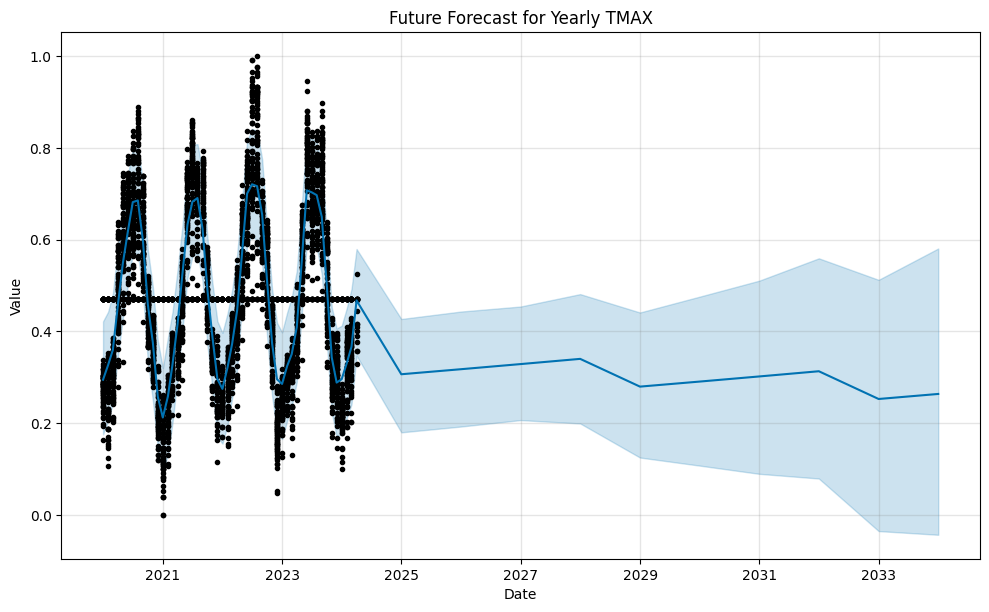

Global Daily Prophet RMSE: 0.6381113292827358
Global Monthly Prophet RMSE: 0.32364715513665626
Global Yearly Prophet RMSE: 0.19182321359986987


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')


# Function to normalize data
def normalize_data(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler


# Function to prepare data for Prophet
def prepare_prophet_data(df, column, date_column='DATE'):
    df = df.reset_index()  # Ensure index is not used for date column
    df[date_column] = pd.to_datetime(df[date_column])  # Ensure date column is in datetime format
    data = df[[date_column, column]].dropna().rename(columns={date_column: 'ds', column: 'y'})
    return data

# Function to fit and forecast using Prophet
def forecast_with_prophet(df, column, periods=365, freq='D'):
    data = prepare_prophet_data(df, column)
    model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)
    return model, forecast

# Function to plot the forecast
def plot_prophet_forecast(model, forecast, title):
    fig = model.plot(forecast)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

# Function to split data into training and testing sets
def split_data(df, column, train_ratio=0.8):
    df = df[[column]].dropna()
    train_size = int(len(df) * train_ratio)
    train, test = df[:train_size], df[train_size:]
    return train, test

# Function to fit and forecast using Prophet with RMSE calculation
def forecast_with_prophet_and_rmse(df, column, periods, freq):
    data = prepare_prophet_data(df, column)
    model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)
    forecast = forecast.set_index('ds')
    return forecast['yhat'].iloc[-len(df):].values, np.sqrt(mean_squared_error(df[column].iloc[-len(forecast):], forecast['yhat']))

# Function to plot forecast comparison
def plot_forecast_comparison(df, prophet_forecast, title):
    plt.figure(figsize=(14, 7))
    train = df[:len(df) - len(prophet_forecast)]
    valid = df[len(df) - len(prophet_forecast):]

    plt.plot(train['TMAX'], label='Train')
    plt.plot(valid['TMAX'], label='Test')
    plt.plot(valid.index, prophet_forecast, label='Prophet Forecast', color='green')
    
    plt.xlabel('Date')
    plt.ylabel('TMAX')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Load and preprocess the data
daily_data, monthly_data, yearly_data = load_and_preprocess_data()

if daily_data is None or monthly_data is None or yearly_data is None:
    print("Data loading failed. Please check the file paths and formats.")
else:
    print("Data loaded and preprocessed successfully.")

    # Normalize the data
    columns = ['TMAX']
    daily_data, daily_scaler = normalize_data(daily_data, columns)
    monthly_data, monthly_scaler = normalize_data(monthly_data, columns)
    yearly_data, yearly_scaler = normalize_data(yearly_data, columns)

    # Daily Data
    try:
        daily_train, daily_test = split_data(daily_data, 'TMAX')
        daily_prophet_forecast, daily_prophet_rmse = forecast_with_prophet_and_rmse(daily_data, 'TMAX', periods=len(daily_test), freq='D')
        print(f'Daily Prophet RMSE: {daily_prophet_rmse}')
        plot_forecast_comparison(daily_data, daily_prophet_forecast, 'Forecast Comparison for Daily TMAX')

        # Future predictions for daily data
        future_periods = 365  # Predicting for next 365 days
        daily_future_model, daily_future_forecast = forecast_with_prophet(daily_data, 'TMAX', periods=future_periods, freq='D')
        plot_prophet_forecast(daily_future_model, daily_future_forecast, 'Future Forecast for Daily TMAX')
    except Exception as e:
        print(f"Error forecasting daily TMAX: {e}")

    # Monthly Data
    try:
        monthly_train, monthly_test = split_data(monthly_data, 'TMAX')
        monthly_prophet_forecast, monthly_prophet_rmse = forecast_with_prophet_and_rmse(monthly_data, 'TMAX', periods=len(monthly_test), freq='M')
        print(f'Monthly Prophet RMSE: {monthly_prophet_rmse}')
        plot_forecast_comparison(monthly_data, monthly_prophet_forecast, 'Forecast Comparison for Monthly TMAX')

        # Future predictions for monthly data
        future_periods = 12  # Predicting for next 12 months
        monthly_future_model, monthly_future_forecast = forecast_with_prophet(monthly_data, 'TMAX', periods=future_periods, freq='M')
        plot_prophet_forecast(monthly_future_model, monthly_future_forecast, 'Future Forecast for Monthly TMAX')
    except Exception as e:
        print(f"Error forecasting monthly TMAX: {e}")

    # Yearly Data
    try:
        yearly_train, yearly_test = split_data(yearly_data, 'TMAX')
        yearly_periods = min(len(yearly_test), 10)  # Ensure the forecast period is reasonable
        yearly_prophet_forecast, yearly_prophet_rmse = forecast_with_prophet_and_rmse(yearly_data, 'TMAX', periods=yearly_periods, freq='A')
        print(f'Yearly Prophet RMSE: {yearly_prophet_rmse}')
        plot_forecast_comparison(yearly_data, yearly_prophet_forecast, 'Forecast Comparison for Yearly TMAX')

        # Future predictions for yearly data
        future_periods = 10  # Predicting for next 10 years
        yearly_future_model, yearly_future_forecast = forecast_with_prophet(yearly_data, 'TMAX', periods=future_periods, freq='A')
        plot_prophet_forecast(yearly_future_model, yearly_future_forecast, 'Future Forecast for Yearly TMAX')
    except Exception as e:
        print(f"Error forecasting yearly TMAX: {e}")

    # Print global RMSE values
    print(f'Global Daily Prophet RMSE: {daily_prophet_rmse}')
    print(f'Global Monthly Prophet RMSE: {monthly_prophet_rmse}')
    print(f'Global Yearly Prophet RMSE: {yearly_prophet_rmse}')


Daily ARIMA RMSE: 0.20489937222005425


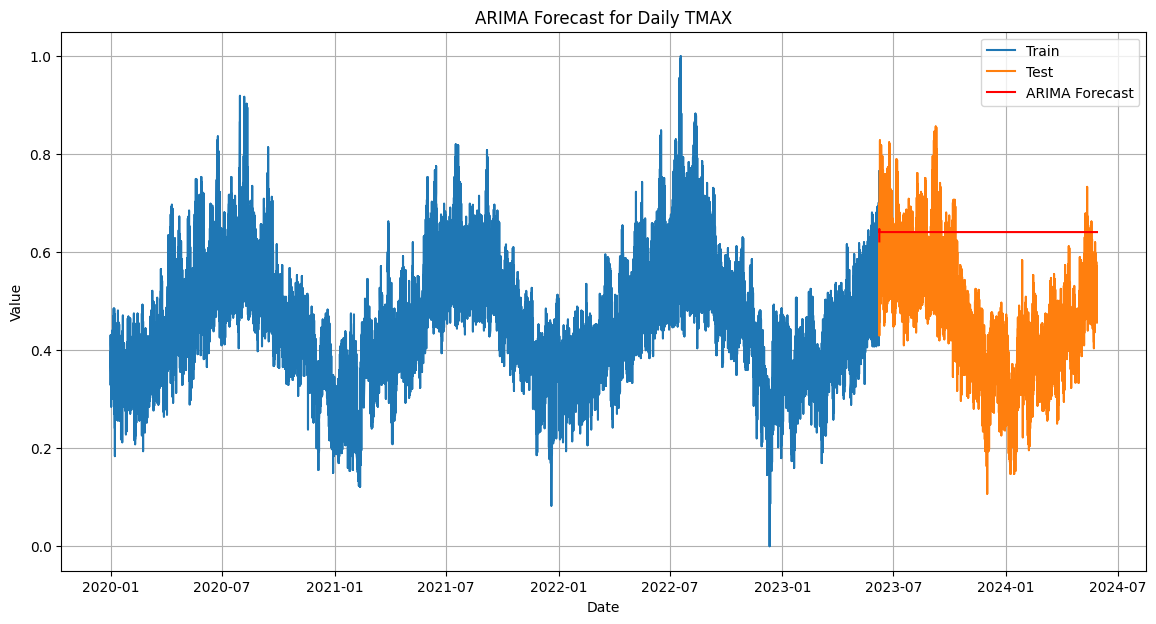

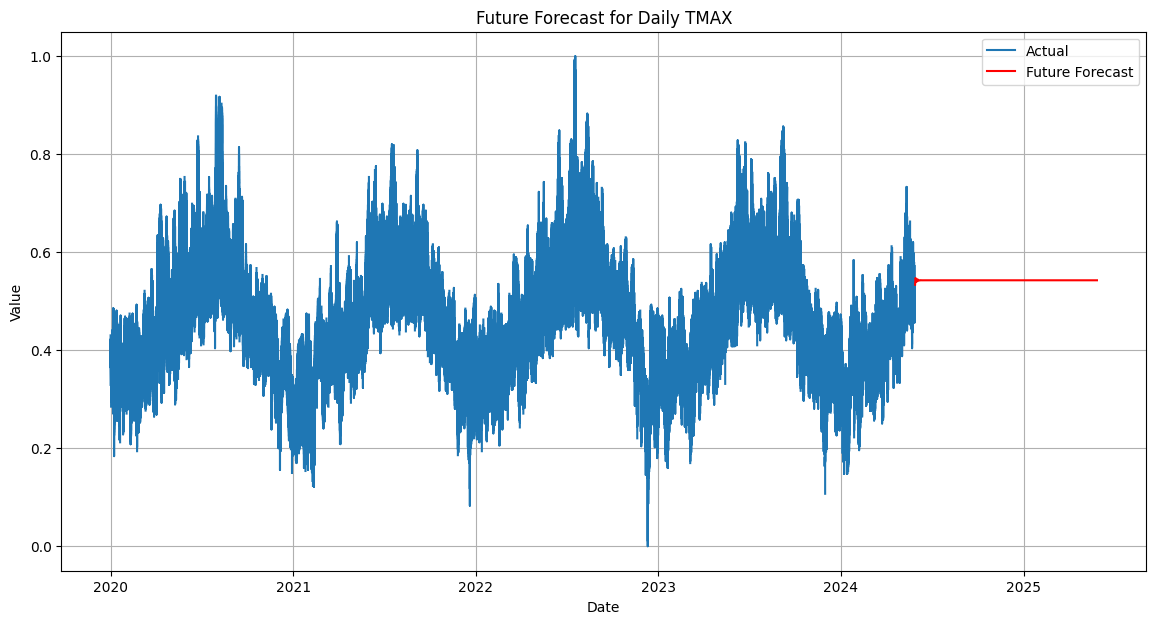

Monthly ARIMA RMSE: 0.21297885930087831


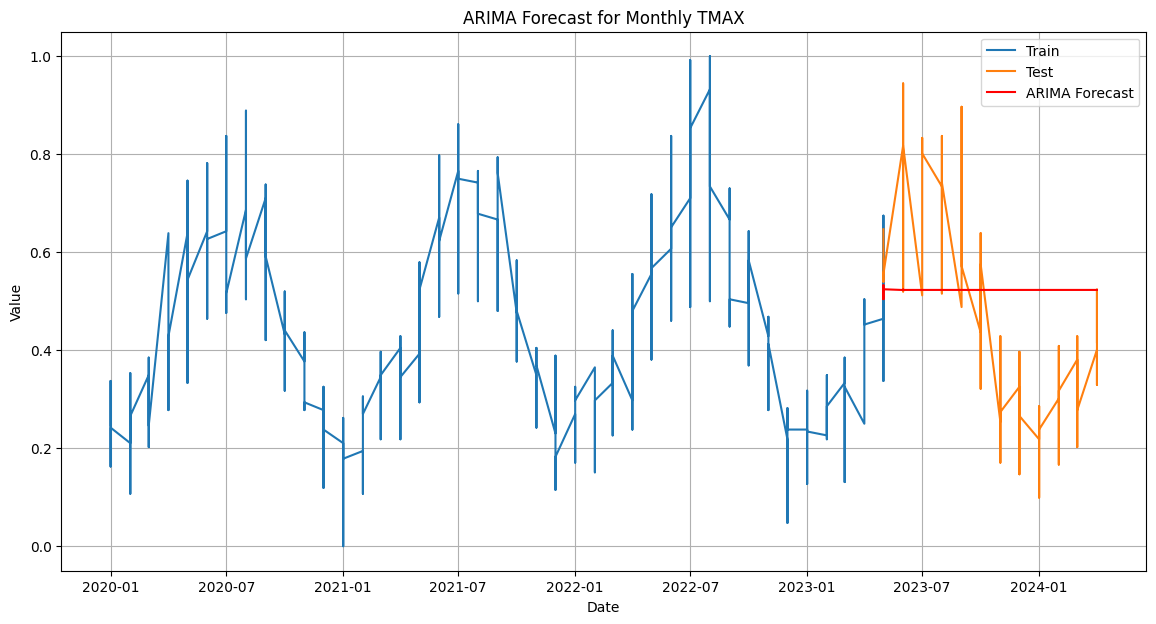

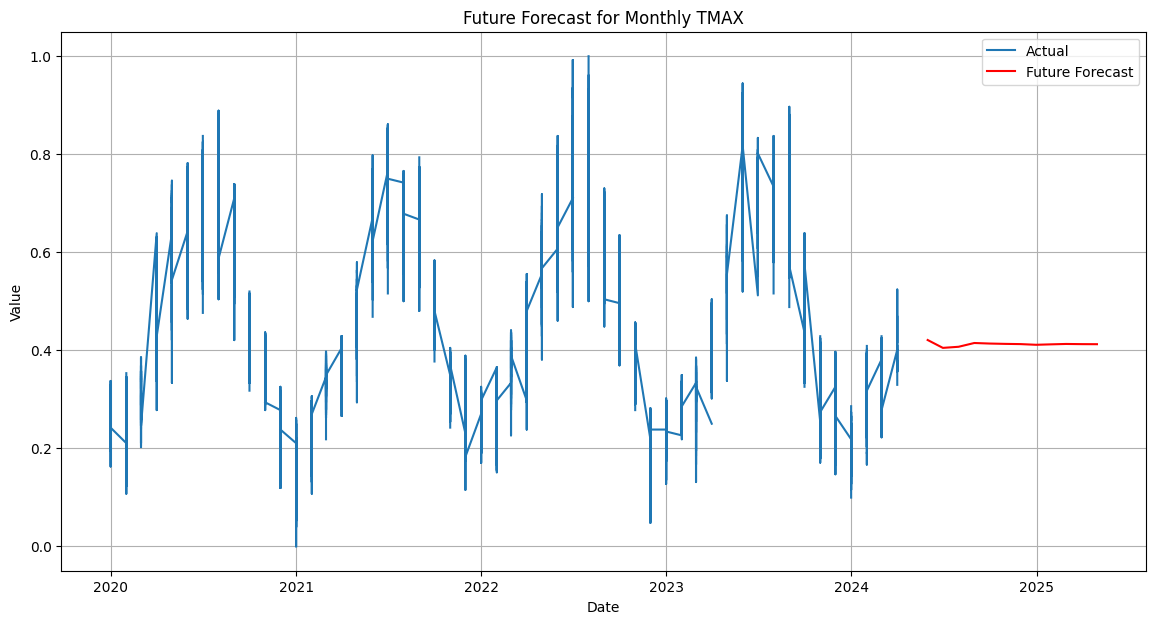

Yearly ARIMA RMSE: 0.21297885930087831


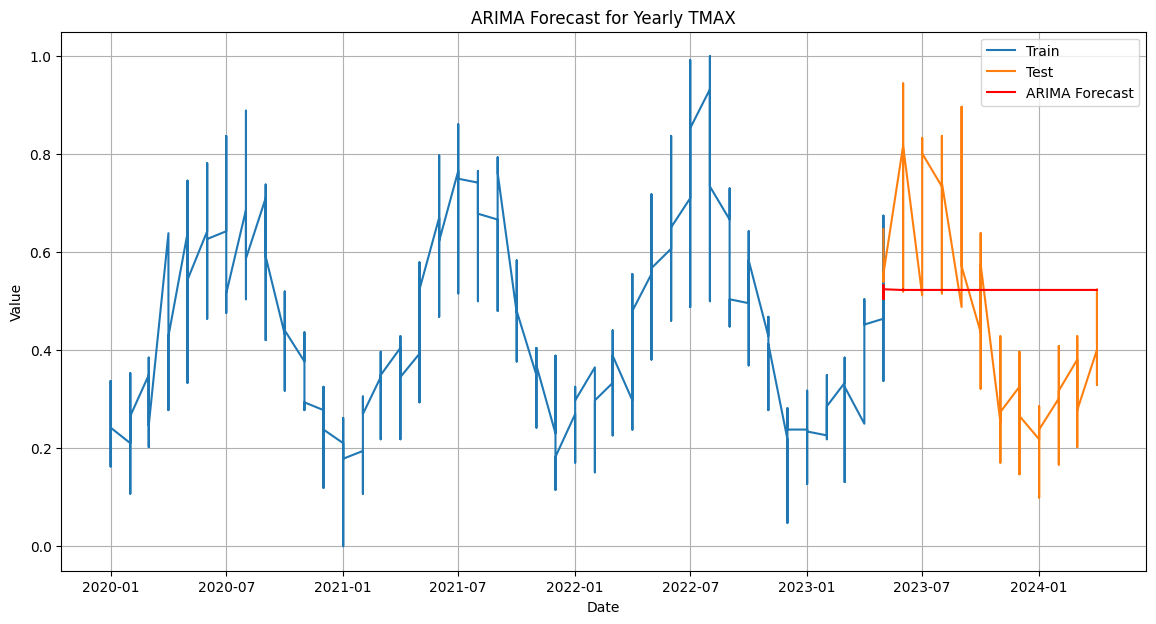

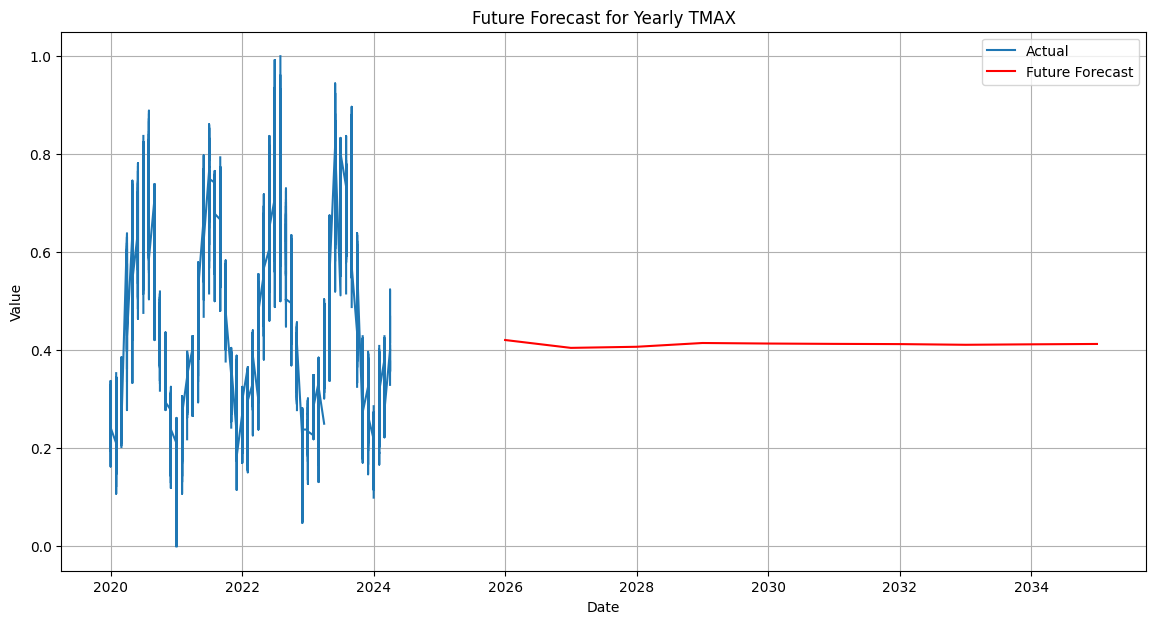

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

# Function to normalize data
def normalize_data(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler

# Function to split data into training and testing sets
def split_data(df, column, train_ratio=0.8):
    df = df[[column]].dropna()
    train_size = int(len(df) * train_ratio)
    train, test = df[:train_size], df[train_size:]
    return train, test

# Function to fit and forecast using ARIMA
def forecast_with_arima(train, test, order):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast, model_fit

# Function to plot ARIMA forecast comparison
def plot_arima_forecast(train, test, forecast, title):
    plt.figure(figsize=(14, 7))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to forecast future values using ARIMA
def forecast_future_arima(data, order, periods, freq):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    future_index = pd.date_range(start=data.index[-1], periods=periods+1, freq=freq)[1:]
    future_forecast = model_fit.forecast(steps=periods)
    future_forecast.index = future_index
    return future_forecast, model_fit

# Function to plot ARIMA future forecast
def plot_future_arima_forecast(data, future_forecast, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data, label='Actual')
    plt.plot(future_forecast.index, future_forecast, label='Future Forecast', color='red')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Load and preprocess the data
daily_data = pd.read_csv('Daily Summaries - GHCND.csv', parse_dates=['DATE'], index_col='DATE')
monthly_data = pd.read_csv('Global Summary of the Month - GSOM.csv', parse_dates=['DATE'], index_col='DATE')
yearly_data = pd.read_csv('Global Summary of The Year - GSOY.csv', parse_dates=['DATE'], index_col='DATE')

# Sort the data by date
daily_data = daily_data.sort_index()
monthly_data = monthly_data.sort_index()
yearly_data = yearly_data.sort_index()

# Normalize the data
columns = ['TMAX']
daily_data, daily_scaler = normalize_data(daily_data, columns)
monthly_data, monthly_scaler = normalize_data(monthly_data, columns)
yearly_data, yearly_scaler = normalize_data(yearly_data, columns)

# Daily Data
try:
    daily_train, daily_test = split_data(daily_data, 'TMAX')
    daily_forecast, daily_model_fit = forecast_with_arima(daily_train, daily_test, order=(5, 1, 0))
    daily_rmse = np.sqrt(mean_squared_error(daily_test, daily_forecast))
    print(f'Daily ARIMA RMSE: {daily_rmse}')
    plot_arima_forecast(daily_train, daily_test, daily_forecast, 'ARIMA Forecast for Daily TMAX')

    # Future predictions for daily data
    future_periods = 365  # Predicting for next 365 days
    daily_future_forecast, daily_future_model_fit = forecast_future_arima(daily_data['TMAX'], order=(5, 1, 0), periods=future_periods, freq='D')
    plot_future_arima_forecast(daily_data['TMAX'], daily_future_forecast, 'Future Forecast for Daily TMAX')
except Exception as e:
    print(f"Error forecasting daily TMAX: {e}")

# Monthly Data
try:
    monthly_train, monthly_test = split_data(monthly_data, 'TMAX')
    monthly_forecast, monthly_model_fit = forecast_with_arima(monthly_train, monthly_test, order=(5, 1, 0))
    monthly_rmse = np.sqrt(mean_squared_error(monthly_test, monthly_forecast))
    print(f'Monthly ARIMA RMSE: {monthly_rmse}')
    plot_arima_forecast(monthly_train, monthly_test, monthly_forecast, 'ARIMA Forecast for Monthly TMAX')

    # Future predictions for monthly data
    future_periods = 12  # Predicting for next 12 months
    monthly_future_forecast, monthly_future_model_fit = forecast_future_arima(monthly_data['TMAX'], order=(5, 1, 0), periods=future_periods, freq='M')
    plot_future_arima_forecast(monthly_data['TMAX'], monthly_future_forecast, 'Future Forecast for Monthly TMAX')
except Exception as e:
    print(f"Error forecasting monthly TMAX: {e}")

# Yearly Data
try:
    yearly_train, yearly_test = split_data(yearly_data, 'TMAX')
    yearly_forecast, yearly_model_fit = forecast_with_arima(yearly_train, yearly_test, order=(5, 1, 0))
    yearly_rmse = np.sqrt(mean_squared_error(yearly_test, yearly_forecast))
    print(f'Yearly ARIMA RMSE: {yearly_rmse}')
    plot_arima_forecast(yearly_train, yearly_test, yearly_forecast, 'ARIMA Forecast for Yearly TMAX')

    # Future predictions for yearly data
    future_periods = 10  # Predicting for next 10 years
    yearly_future_forecast, yearly_future_model_fit = forecast_future_arima(yearly_data['TMAX'], order=(5, 1, 0), periods=future_periods, freq='A')
    plot_future_arima_forecast(yearly_data['TMAX'], yearly_future_forecast, 'Future Forecast for Yearly TMAX')
except Exception as e:
    print(f"Error forecasting yearly TMAX: {e}")


ARIMA(0, 0, 0) RMSE=0.12324264542635922
ARIMA(0, 0, 1) RMSE=0.12324022357611991
ARIMA(0, 0, 2) RMSE=0.12323900936624223
ARIMA(0, 1, 0) RMSE=0.2465981663389092
ARIMA(0, 1, 1) RMSE=0.19215446288993843
ARIMA(0, 1, 2) RMSE=0.1921638034983676
ARIMA(0, 2, 0) RMSE=488.3046010688944
ARIMA(0, 2, 1) RMSE=0.9974996228147468
ARIMA(0, 2, 2) RMSE=8.5687337338452
ARIMA(1, 0, 0) RMSE=0.12321829848772087
ARIMA(1, 0, 1) RMSE=0.10819439118328134
ARIMA(1, 0, 2) RMSE=0.11238890294696478
ARIMA(1, 1, 0) RMSE=0.23621553248493057
ARIMA(1, 1, 1) RMSE=0.192163679526323
ARIMA(1, 1, 2) RMSE=0.1921531441779709
ARIMA(1, 2, 0) RMSE=726.1682689540291
ARIMA(1, 2, 1) RMSE=1.0301029408832711
ARIMA(1, 2, 2) RMSE=1.0143721114616076
ARIMA(2, 0, 0) RMSE=0.12314667555033901
ARIMA(2, 0, 1) RMSE=0.1108364231542121
ARIMA(2, 0, 2) RMSE=0.10973647020386389
ARIMA(2, 1, 0) RMSE=0.2196024919614467
ARIMA(2, 1, 1) RMSE=0.19219192471935898
ARIMA(2, 1, 2) RMSE=0.19218541292973712
ARIMA(2, 2, 0) RMSE=519.4841375199609
ARIMA(2, 2, 1) RMSE=

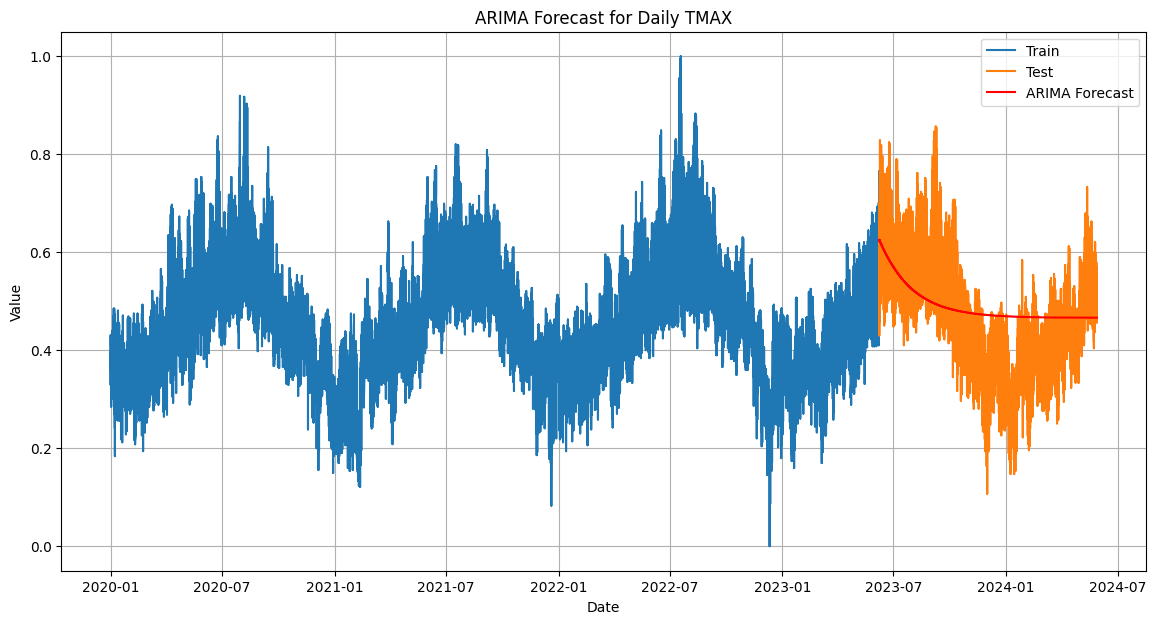

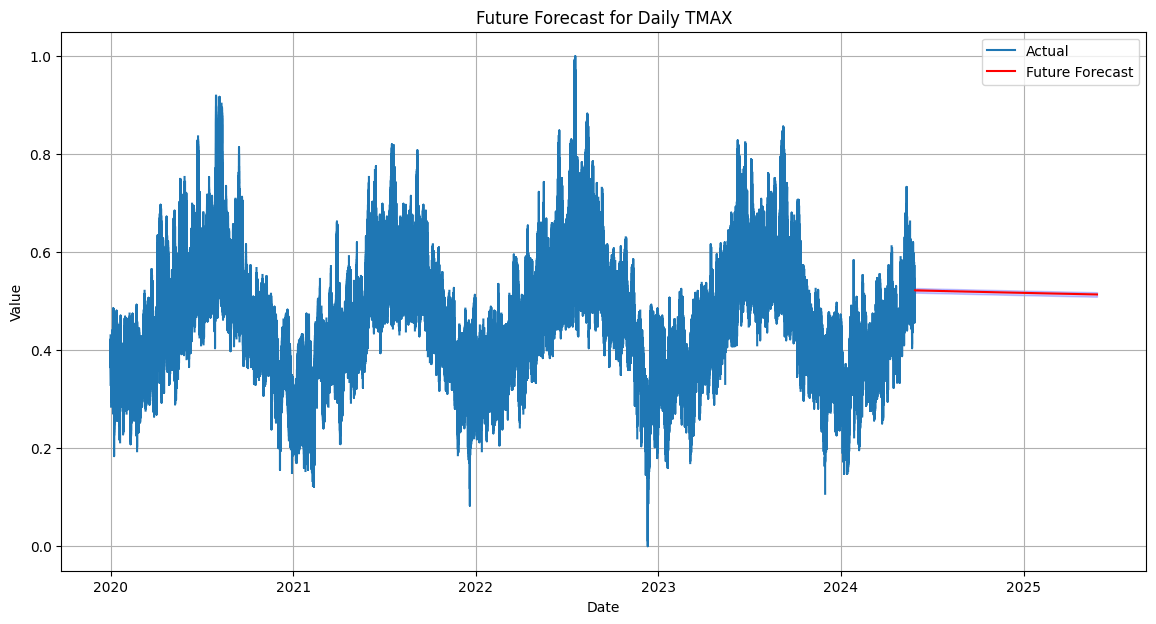

ARIMA(0, 0, 0) RMSE=0.21410642727834236
ARIMA(0, 0, 1) RMSE=0.21420397256570364
ARIMA(0, 0, 2) RMSE=0.21404753384842246
ARIMA(0, 1, 0) RMSE=0.2116451202307757
ARIMA(0, 1, 1) RMSE=0.21658875710737285
ARIMA(0, 1, 2) RMSE=0.21630751155382186
ARIMA(0, 2, 0) RMSE=34.58031451077865
ARIMA(0, 2, 1) RMSE=0.23151030762459085
ARIMA(0, 2, 2) RMSE=0.5252186938340629
ARIMA(1, 0, 0) RMSE=0.21363290403281465
ARIMA(1, 0, 1) RMSE=0.1940766632662485
ARIMA(1, 0, 2) RMSE=0.20001054471360272
ARIMA(1, 1, 0) RMSE=0.21492292717653286
ARIMA(1, 1, 1) RMSE=0.2163402566659304
ARIMA(1, 1, 2) RMSE=0.21658355000839785
ARIMA(1, 2, 0) RMSE=2.2050829817792206
ARIMA(1, 2, 1) RMSE=0.23957638216625832
ARIMA(1, 2, 2) RMSE=0.5124065299404738
ARIMA(2, 0, 0) RMSE=0.21129927221659803
ARIMA(2, 0, 1) RMSE=0.19407767096373657
ARIMA(2, 0, 2) RMSE=0.19400625964683
ARIMA(2, 1, 0) RMSE=0.2141144275447742
ARIMA(2, 1, 1) RMSE=0.21611798056145015
ARIMA(2, 1, 2) RMSE=0.21616098697569275
ARIMA(2, 2, 0) RMSE=4.957165249689137
ARIMA(2, 2, 1)

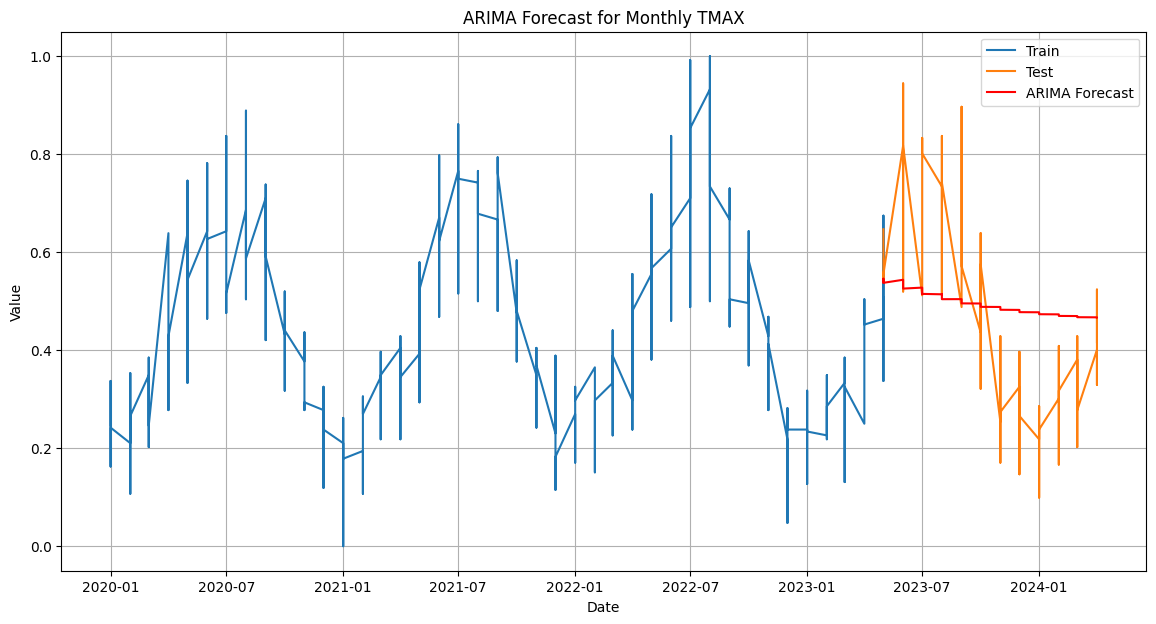

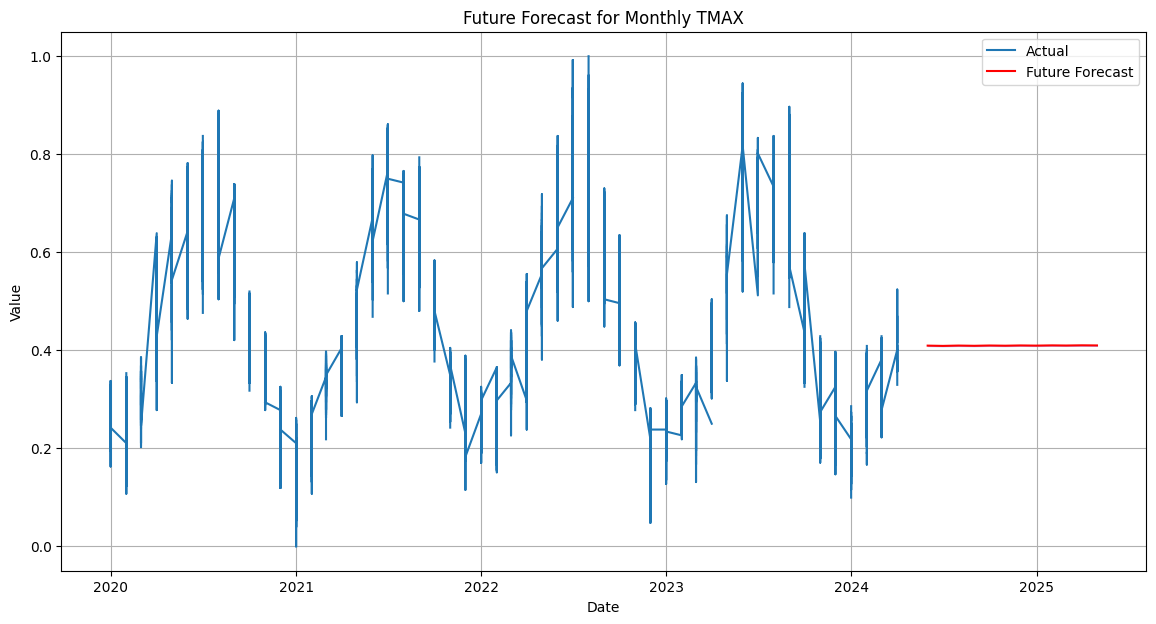

ARIMA(0, 0, 0) RMSE=0.21410642727834236
ARIMA(0, 0, 1) RMSE=0.21420397256570364
ARIMA(0, 0, 2) RMSE=0.21404753384842246
ARIMA(0, 1, 0) RMSE=0.2116451202307757
ARIMA(0, 1, 1) RMSE=0.21658875710737285
ARIMA(0, 1, 2) RMSE=0.21630751155382186
ARIMA(0, 2, 0) RMSE=34.58031451077865
ARIMA(0, 2, 1) RMSE=0.23151030762459085
ARIMA(0, 2, 2) RMSE=0.5252186938340629
ARIMA(1, 0, 0) RMSE=0.21363290403281465
ARIMA(1, 0, 1) RMSE=0.1940766632662485
ARIMA(1, 0, 2) RMSE=0.20001054471360272
ARIMA(1, 1, 0) RMSE=0.21492292717653286
ARIMA(1, 1, 1) RMSE=0.2163402566659304
ARIMA(1, 1, 2) RMSE=0.21658355000839785
ARIMA(1, 2, 0) RMSE=2.2050829817792206
ARIMA(1, 2, 1) RMSE=0.23957638216625832
ARIMA(1, 2, 2) RMSE=0.5124065299404738
ARIMA(2, 0, 0) RMSE=0.21129927221659803
ARIMA(2, 0, 1) RMSE=0.19407767096373657
ARIMA(2, 0, 2) RMSE=0.19400625964683
ARIMA(2, 1, 0) RMSE=0.2141144275447742
ARIMA(2, 1, 1) RMSE=0.21611798056145015
ARIMA(2, 1, 2) RMSE=0.21616098697569275
ARIMA(2, 2, 0) RMSE=4.957165249689137
ARIMA(2, 2, 1)

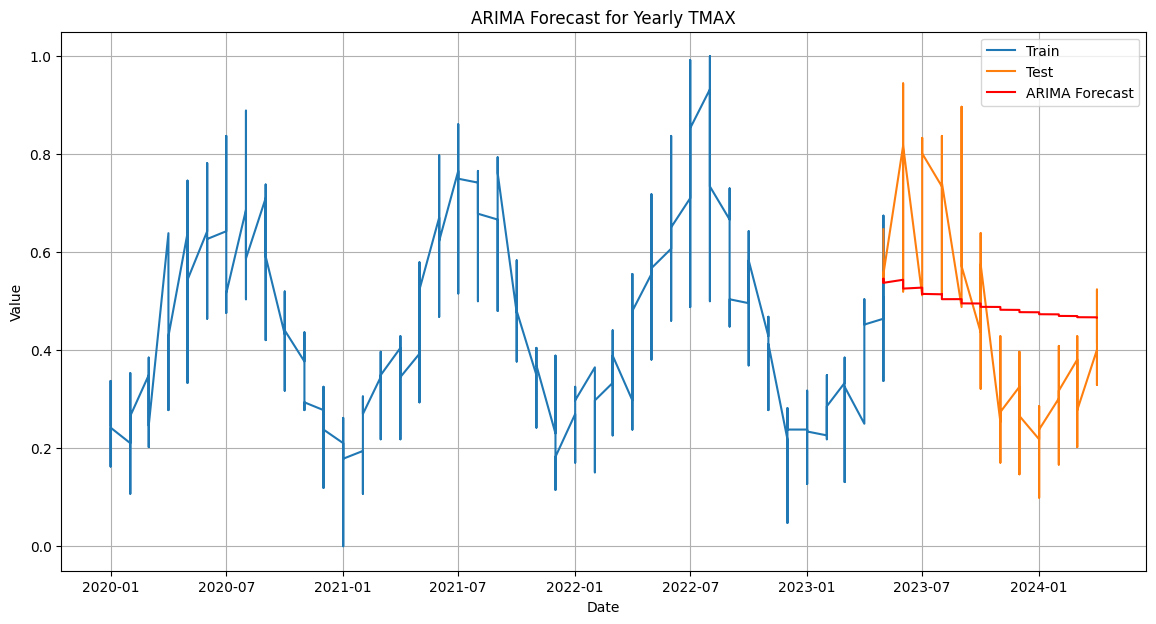

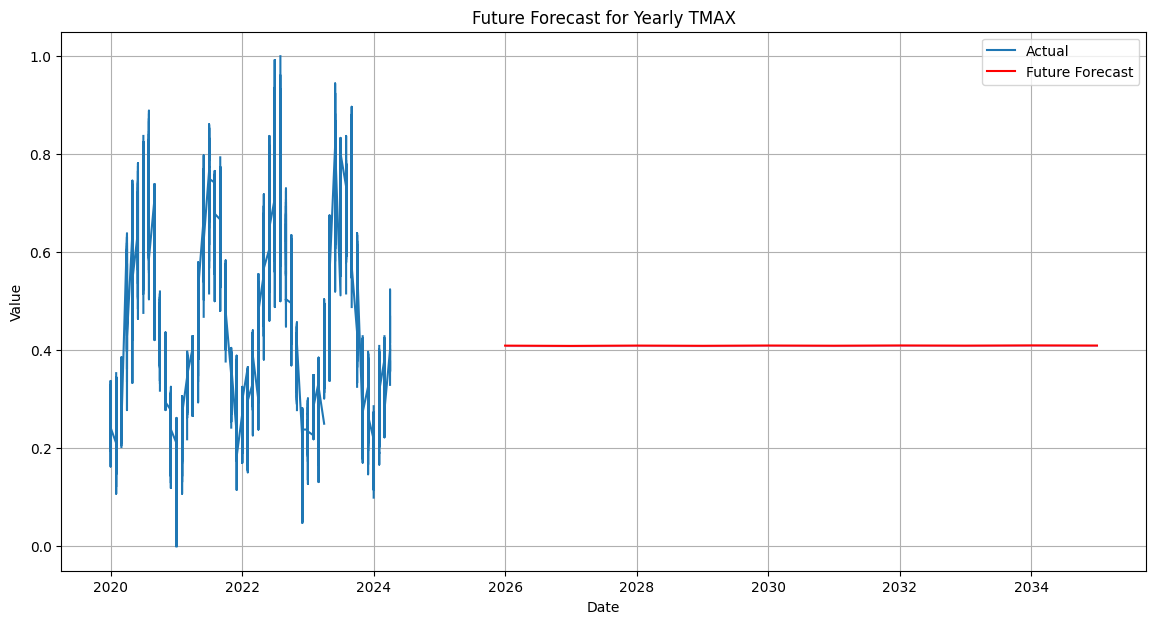

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings
import itertools

warnings.filterwarnings('ignore')

# Function to normalize data
def normalize_data(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler

# Function to split data into training and testing sets
def split_data(df, column, train_ratio=0.8):
    df = df[[column]].dropna()
    train_size = int(len(df) * train_ratio)
    train, test = df[:train_size], df[train_size:]
    return train, test

# Function to fit and forecast using ARIMA
def forecast_with_arima(train, test, order):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast, model_fit

# Function to plot ARIMA forecast comparison
def plot_arima_forecast(train, test, forecast, title):
    plt.figure(figsize=(14, 7))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to forecast future values using ARIMA
def forecast_future_arima(data, order, periods, freq):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    future_index = pd.date_range(start=data.index[-1], periods=periods + 1, freq=freq)[1:]
    future_forecast = model_fit.forecast(steps=periods)
    future_forecast.index = future_index
    return future_forecast, model_fit

# Function to plot ARIMA future forecast
def plot_future_arima_forecast(data, future_forecast, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data, label='Actual')
    plt.plot(future_forecast.index, future_forecast, label='Future Forecast', color='red')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.fill_between(future_forecast.index, future_forecast - 1.96 * future_forecast.std(), 
                     future_forecast + 1.96 * future_forecast.std(), color='blue', alpha=0.2)
    plt.show()

# Grid search for ARIMA parameters
def arima_grid_search(train, test, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            order = (p, d, q)
            forecast, model_fit = forecast_with_arima(train, test, order)
            rmse = np.sqrt(mean_squared_error(test, forecast))
            if rmse < best_score:
                best_score, best_cfg = rmse, order
            print(f'ARIMA{order} RMSE={rmse}')
        except Exception as e:
            continue
    print(f'Best ARIMA{best_cfg} RMSE={best_score}')
    return best_cfg

# Load and preprocess the data
daily_data = pd.read_csv('Daily Summaries - GHCND.csv', parse_dates=['DATE'], index_col='DATE')
monthly_data = pd.read_csv('Global Summary of the Month - GSOM.csv', parse_dates=['DATE'], index_col='DATE')
yearly_data = pd.read_csv('Global Summary of The Year - GSOY.csv', parse_dates=['DATE'], index_col='DATE')

# Sort the data by date
daily_data = daily_data.sort_index()
monthly_data = monthly_data.sort_index()
yearly_data = yearly_data.sort_index()

# Normalize the data
columns = ['TMAX']
daily_data, daily_scaler = normalize_data(daily_data, columns)
monthly_data, monthly_scaler = normalize_data(monthly_data, columns)
yearly_data, yearly_scaler = normalize_data(yearly_data, columns)

# ARIMA parameters
p_values = [0, 1, 2, 4, 6]
d_values = [0, 1, 2]
q_values = [0, 1, 2]

# Daily Data
try:
    daily_train, daily_test = split_data(daily_data, 'TMAX')
    best_order_daily = arima_grid_search(daily_train, daily_test, p_values, d_values, q_values)
    daily_forecast, daily_model_fit = forecast_with_arima(daily_train, daily_test, best_order_daily)
    daily_rmse = np.sqrt(mean_squared_error(daily_test, daily_forecast))
    print(f'Daily ARIMA RMSE: {daily_rmse}')
    plot_arima_forecast(daily_train, daily_test, daily_forecast, 'ARIMA Forecast for Daily TMAX')

    # Future predictions for daily data
    future_periods = 365  # Predicting for next 365 days
    daily_future_forecast, daily_future_model_fit = forecast_future_arima(daily_data['TMAX'], order=best_order_daily, periods=future_periods, freq='D')
    plot_future_arima_forecast(daily_data['TMAX'], daily_future_forecast, 'Future Forecast for Daily TMAX')
except Exception as e:
    print(f"Error forecasting daily TMAX: {e}")

# Monthly Data
try:
    monthly_train, monthly_test = split_data(monthly_data, 'TMAX')
    best_order_monthly = arima_grid_search(monthly_train, monthly_test, p_values, d_values, q_values)
    monthly_forecast, monthly_model_fit = forecast_with_arima(monthly_train, monthly_test, best_order_monthly)
    monthly_rmse = np.sqrt(mean_squared_error(monthly_test, monthly_forecast))
    print(f'Monthly ARIMA RMSE: {monthly_rmse}')
    plot_arima_forecast(monthly_train, monthly_test, monthly_forecast, 'ARIMA Forecast for Monthly TMAX')

    # Future predictions for monthly data
    future_periods = 12  # Predicting for next 12 months
    monthly_future_forecast, monthly_future_model_fit = forecast_future_arima(monthly_data['TMAX'], order=best_order_monthly, periods=future_periods, freq='M')
    plot_future_arima_forecast(monthly_data['TMAX'], monthly_future_forecast, 'Future Forecast for Monthly TMAX')
except Exception as e:
    print(f"Error forecasting monthly TMAX: {e}")

# Yearly Data
try:
    yearly_train, yearly_test = split_data(yearly_data, 'TMAX')
    best_order_yearly = arima_grid_search(yearly_train, yearly_test, p_values, d_values, q_values)
    yearly_forecast, yearly_model_fit = forecast_with_arima(yearly_train, yearly_test, best_order_yearly)
    yearly_rmse = np.sqrt(mean_squared_error(yearly_test, yearly_forecast))
    print(f'Yearly ARIMA RMSE: {yearly_rmse}')
    plot_arima_forecast(yearly_train, yearly_test, yearly_forecast, 'ARIMA Forecast for Yearly TMAX')

    # Future predictions for yearly data
    future_periods = 10  # Predicting for next 10 years
    yearly_future_forecast, yearly_future_model_fit = forecast_future_arima(yearly_data['TMAX'], order=best_order_yearly, periods=future_periods, freq='A')
    plot_future_arima_forecast(yearly_data['TMAX'], yearly_future_forecast, 'Future Forecast for Yearly TMAX')
except Exception as e:
    print(f"Error forecasting yearly TMAX: {e}")
